In [37]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym

In [38]:
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def display_frames_as_gif(frames):
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0),
              dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    
    def animate(i):
        patch.set_data(frames[i])
        
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames),
                                  interval=50)
    anim.save('movie_cartpole_PXR.mp4')
    display(display_animation(anim, default_mode='loop'))

In [39]:
from collections import namedtuple

Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward'))

In [40]:
ENV = 'CartPole-v0'
GAMMA = 0.99
MAX_STEPS = 200
NUM_EPISODES = 500

In [41]:
class ReplayMemory:

    def __init__(self, CAPACITY):
        self.capacity = CAPACITY
        self.memory = []
        self.index = 0

    def push(self, state, action, state_next, reward):

        if len(self.memory) < self.capacity:
            self.memory.append(None)

        self.memory[self.index] = Transition(state, action, state_next, reward)

        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [42]:
TD_ERROR_EPSILON = 0.0001

class TDerrorMemory:

    def __init__(self, CAPACITY):
        self.capacity = CAPACITY #メモリの最大長
        self.memory = []#経験を保存する変数
        self.index = 0#保存するindexを示す変数

    def push(self, td_error):
        '''TD誤差をメモリに保存'''

        if len(self.memory) < self.capacity:
            self.memory.append(None)

        self.memory[self.index] = td_error
        self.index = (self.index + 1) % self.capacity

    def __len__(self):
        '''関数lenに対して、現在の変数memoryの長さを返す'''
        return len(self.memory)

    def get_prioritized_indexes(self, batch_size):
        '''TD誤差に応じた確率でindexを取得'''

        #TD誤差の和を計算
        sum_absolute_td_error = np.sum(np.absolute(self.memory))
        sum_absolute_td_error += TD_ERROR_EPSILON * len(self.memory)

        #batch_size分の乱数を生成して、昇順に並べる
        rand_list = np.random.uniform(0, sum_absolute_td_error, batch_size)
        rand_list = np.sort(rand_list)

        #作成した乱数で串刺しにして、インデックスを求める
        indexes = []
        idx = 0
        tmp_sum_absolute_td_error = 0
        for rand_num in rand_list:
            while tmp_sum_absolute_td_error < rand_num:
                tmp_sum_absolute_td_error += (abs(self.memory[idx]) + TD_ERROR_EPSILON)
                idx += 1

            #微小値を計算に使用した関係でindexがメモリの長さを超えた場合の補正
            if idx >= len(self.memory):
                idx = len(self.memory) - 1
            indexes.append(idx)

        return indexes

    def update_td_error(self, updated_td_errors):
        '''TD誤差の更新'''
        self.memory = updated_td_errors

In [43]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self, n_in, n_mid, n_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in, n_mid)
        self.fc2 = nn.Linear(n_mid, n_mid)
        self.fc3 = nn.Linear(n_mid, n_out)

    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        output = self.fc3(h2)
        return output

In [44]:
import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

BATCH_SIZE = 32
CAPACITY = 10000

class Brain:
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions #CartPoleの行動
        self.memory = ReplayMemory(CAPACITY)#経験を記憶するメモリオブジェクト

        #ニューラルネットワーク構築
        n_in, n_mid, n_out = num_states, 32, num_actions
        self.main_q_network = Net(n_in, n_mid, n_out)
        self.target_q_network = Net(n_in, n_mid, n_out)
        print(self.main_q_network)#ネットワークの形を出力

        self.optimizer = optim.Adam(self.main_q_network.parameters(), lr=0.0001)#最適化手法の設定

        self.td_error_memory = TDerrorMemory(CAPACITY)

    def replay(self, episode):
        '''Experience Replayでネットワークの結合パラメータを学習'''
        #1. メモリサイズの確認
        if len(self.memory) < BATCH_SIZE:
            return
        
        #2. ミニバッチ作成
        self.batch, self.state_batch, self.action_batch, self.reward_batch, self.non_final_next_states = self.make_minibatch(episode)

        #3. 教師信号となるQ(s_t, a_t)値を求める
        self.expected_state_action_values = self.get_expected_state_action_values()

        #4. 結合パラメータの更新
        self.update_main_q_network()

    def decide_action(self, state, episode):
        epsilon = 0.5 * (1 / (episode + 1))

        if epsilon <= np.random.uniform(0, 1):
            self.main_q_network.eval()#推論モードに切り替え
            with torch.no_grad():
                action = self.main_q_network(state).max(1)[1].view(1, 1)
        else:
            action = torch.LongTensor([[random.randrange(self.num_actions)]])

        return action

    def make_minibatch(self, episode):
        '''2.ミニバッチの作成'''

        #2.1 メモリからミニバッチ分のデータを取り出す
        if episode < 30:
            transitions = self.memory.sample(BATCH_SIZE)
        else:
            #TD誤差に応じてミニバッチを取り出す
            indexes = self.td_error_memory.get_prioritized_indexes(BATCH_SIZE)
            transitions = [self.memory.memory[n] for n in indexes]

        #2.2 各変数をミニバッチに対応する形に変形
        batch = Transition(*zip(*transitions))

        #2.3 各変数の要素をミニバッチに対応する形に変形する
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

        return batch, state_batch, action_batch, reward_batch, non_final_next_states

    def get_expected_state_action_values(self):
        '''3.教師信号となるQ(s_t, a_t)値を求める'''

        #3.1 ネットワークを推論モードに切り替え
        self.main_q_network.eval()
        self.target_q_network.eval()

        #3.2 ネットワークが出力したQ(s_t, a_t)を求める
        self.state_action_values = self.main_q_network(self.state_batch).gather(1, self.action_batch)

        #3.3 max{Q(s_t+1, a)}値を求める。ただし次の状態があるかに注意
        non_final_mask = torch.ByteTensor(tuple(map(lambda s: s is not None, self.batch.next_state)))

        next_state_values = torch.zeros(BATCH_SIZE)

        a_m = torch.zeros(BATCH_SIZE).type(torch.LongTensor)

        a_m[non_final_mask] = self.main_q_network(
            self.non_final_next_states).detach().max(1)[1]

        a_m_non_final_next_states = a_m[non_final_mask].view(-1, 1)

        next_state_values[non_final_mask] = self.target_q_network(self.non_final_next_states).gather(1, a_m_non_final_next_states).detach().squeeze()

        #3.4 教師となるQ(s_t, a_t)値を、Q学習の式から求める
        expected_state_action_values = self.reward_batch + GAMMA * next_state_values

        return expected_state_action_values

    def update_main_q_network(self):
        '''4. 結合パラメータの更新'''

        #4.1 ネットワークを訓練モードに切り替える
        self.main_q_network.train()

        #4.2 損失関数を計算する(smooth_l1_lossはHuberloss)
        loss = F.smooth_l1_loss(self.state_action_values, self.expected_state_action_values.unsqueeze(1))

        #4.3 結合パラメータを更新する
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_q_network(self):
        '''Target Q-NetworkをMainと同じにする'''
        self.target_q_network.load_state_dict(self.main_q_network.state_dict())

    def update_td_error_memory(self):
        '''TD誤差メモリに格納されているTD誤差を更新する'''

        #ネットワークを推論モードに
        self.main_q_network.eval()
        self.target_q_network.eval()

        #全メモリでミニバッチを作成
        transitions = self.memory.memory
        batch = Transition(*zip(*transitions))

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

        #ネットワークが出力したQ(s_t, a_t)を求める
        state_action_values = self.main_q_network(state_batch).gather(1, action_batch)

        #cartpoleがdoneになっておらず、next_stateがあるかをチェックするインデックスマスクを作成
        non_final_mask = torch.ByteTensor(tuple(map(lambda s: s is not None, batch.next_state)))

        #まずは全部0にしておく、サイズはメモリの長さ
        next_state_values = torch.zeros(len(self.memory))
        a_m = torch.zeros(len(self.memory)).type(torch.LongTensor)

        #次の状態での最大Q値の行動a_mをMain Q-networkから求める
        a_m[non_final_mask] = self.main_q_network(non_final_next_states).detach().max(1)[1]

        #次の状態があるものだけにフィルターし、size 32を32*1へ
        a_m_non_final_next_states = a_m[non_final_mask].view(-1, 1)

        #次の状態があるindexの、行動a_mのQ値をtarget Q-networkから求める
        next_state_values[non_final_mask] = self.target_q_network(non_final_next_states).gather(1, a_m_non_final_next_states).detach().squeeze()

        #TD誤差を求める
        td_errors = (reward_batch + GAMMA * next_state_values) - \
            state_action_values.squeeze()

        #TD誤差メモリを更新、Tensorをdetach()で取り出し、NumPyにしてから、Pythonのリストまで変換
        self.td_error_memory.memory = td_errors.detach().numpy().tolist()

In [45]:
class Agent:
    def __init__(self, num_states, num_actions):
        '''課題の状態と行動の数を設定する'''
        self.brain = Brain(num_states, num_actions) 

    def update_q_function(self, episode):
        '''Q関数を更新する'''
        self.brain.replay(episode)

    def get_action(self, state, episode):
        '''行動を決定する'''
        action = self.brain.decide_action(state, episode)
        return action

    def memorize(self, state, action, state_next, reward):
        '''memoryオブジェクトに、state, action, state_next, rewardの内容を保存する'''
        self.brain.memory.push(state, action, state_next, reward)

    def update_target_q_function(self):
        '''Target Q-NetworkをMain Q-Networkと同じに更新'''
        self.brain.update_target_q_network()
        
    def memorize_td_error(self, td_error):  
        '''TD誤差メモリにTD誤差を格納'''
        self.brain.td_error_memory.push(td_error)
        
    def update_td_error_memory(self): 
        '''TD誤差メモリに格納されているTD誤差を更新する'''
        self.brain.update_td_error_memory()

In [48]:
class Environment:
    def __init__(self):
        self.env = gym.make(ENV)
        num_states = self.env.observation_space.shape[0]
        num_actions = self.env.action_space.n

        self.agent = Agent(num_states, num_actions)

    def run(self):
        episode_10_list = np.zeros(10)

        complete_episodes = 0
        episode_final = False
        frames = []

        for episode in range(NUM_EPISODES):
            observation = self.env.reset()

            state = observation
            state = torch.from_numpy(state).type(torch.FloatTensor)
            state = torch.unsqueeze(state, 0)

            for step in range(MAX_STEPS):
                if episode_final is True:
                    frames.append(self.env.render(mode = 'rgb_array'))
                
                action = self.agent.get_action(state, episode)

                observation_next, _, done, _ = self.env.step(action.item())
                if done:
                    state_next = None

                    episode_10_list = np.hstack((episode_10_list[1:], step + 1))

                    if step < 195:
                        reward = torch.FloatTensor([-1.0])
                        complete_episodes = 0
                    else:
                        reward = torch.FloatTensor([1.0])
                        complete_episodes = complete_episodes + 1
                else:
                    reward = torch.FloatTensor([0.0])
                    state_next = observation_next
                    state_next = torch.from_numpy(state_next).type(torch.FloatTensor)
                    state_next = torch.unsqueeze(state_next, 0)

                self.agent.memorize(state, action, state_next, reward)

                self.agent.memorize_td_error(0)

                self.agent.update_q_function(episode)

                state = state_next

                if done:
                    print('%d Episode: Finished after %d steps : 10試行の平均step数 = %.1lf' %(episode, step + 1, episode_10_list.mean()))

                    self.agent.update_td_error_memory()

                    if(episode % 2 == 0):
                        self.agent.update_target_q_function()
                    break

            if episode_final is True:
                display_frames_as_gif(frames)
                break

            if complete_episodes >= 10:
                print('10回連続成功')
                episode_final = True

Net(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)
0 Episode: Finished after 14 steps : 10試行の平均step数 = 1.4
1 Episode: Finished after 9 steps : 10試行の平均step数 = 2.3
2 Episode: Finished after 11 steps : 10試行の平均step数 = 3.4
3 Episode: Finished after 9 steps : 10試行の平均step数 = 4.3
4 Episode: Finished after 10 steps : 10試行の平均step数 = 5.3
5 Episode: Finished after 9 steps : 10試行の平均step数 = 6.2
6 Episode: Finished after 14 steps : 10試行の平均step数 = 7.6
7 Episode: Finished after 8 steps : 10試行の平均step数 = 8.4
8 Episode: Finished after 9 steps : 10試行の平均step数 = 9.3
9 Episode: Finished after 9 steps : 10試行の平均step数 = 10.2
10 Episode: Finished after 9 steps : 10試行の平均step数 = 9.7
11 Episode: Finished after 9 steps : 10試行の平均step数 = 9.7


C:\Users\owner\AppData\Local\Temp/ipykernel_10744/2553595796.py:148: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen/native/IndexingUtils.h:30.)
  a_m[non_final_mask] = self.main_q_network(non_final_next_states).detach().max(1)[1]
C:\Users\owner\AppData\Local\Temp/ipykernel_10744/2553595796.py:151: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen/native/IndexingUtils.h:30.)
  a_m_non_final_next_states = a_m[non_final_mask].view(-1, 1)
C:\Users\owner\AppData\Local\Temp/ipykernel_10744/2553595796.py:154: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen/native/IndexingUtils.h:30.)
  next_state_values[non_final_mask] = self.target_q_network(non_final_next_states).gather(1, a_m_non_final_next_states).det

12 Episode: Finished after 9 steps : 10試行の平均step数 = 9.5
13 Episode: Finished after 10 steps : 10試行の平均step数 = 9.6
14 Episode: Finished after 10 steps : 10試行の平均step数 = 9.6
15 Episode: Finished after 9 steps : 10試行の平均step数 = 9.6
16 Episode: Finished after 9 steps : 10試行の平均step数 = 9.1
17 Episode: Finished after 11 steps : 10試行の平均step数 = 9.4
18 Episode: Finished after 10 steps : 10試行の平均step数 = 9.5
19 Episode: Finished after 10 steps : 10試行の平均step数 = 9.6
20 Episode: Finished after 10 steps : 10試行の平均step数 = 9.7
21 Episode: Finished after 13 steps : 10試行の平均step数 = 10.1
22 Episode: Finished after 13 steps : 10試行の平均step数 = 10.5
23 Episode: Finished after 10 steps : 10試行の平均step数 = 10.5
24 Episode: Finished after 9 steps : 10試行の平均step数 = 10.4
25 Episode: Finished after 12 steps : 10試行の平均step数 = 10.7
26 Episode: Finished after 9 steps : 10試行の平均step数 = 10.7
27 Episode: Finished after 11 steps : 10試行の平均step数 = 10.7
28 Episode: Finished after 12 steps : 10試行の平均step数 = 10.9
29 Episode: Finished after 9

Exception ignored in: <function Viewer.__del__ at 0x000001F9A1431310>
Traceback (most recent call last):
  File "C:\Users\owner\anaconda3\envs\rl_env\lib\site-packages\gym\envs\classic_control\rendering.py", line 152, in __del__
    self.close()
  File "C:\Users\owner\anaconda3\envs\rl_env\lib\site-packages\gym\envs\classic_control\rendering.py", line 71, in close
    self.window.close()
  File "C:\Users\owner\anaconda3\envs\rl_env\lib\site-packages\pyglet\window\win32\__init__.py", line 299, in close
    super(Win32Window, self).close()
  File "C:\Users\owner\anaconda3\envs\rl_env\lib\site-packages\pyglet\window\__init__.py", line 823, in close
    app.windows.remove(self)
  File "C:\Users\owner\anaconda3\envs\rl_env\lib\_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: <weakref at 0x000001F99AD7D040; to 'Win32Window' at 0x000001F99C022A00>


196 Episode: Finished after 60 steps : 10試行の平均step数 = 73.9
197 Episode: Finished after 98 steps : 10試行の平均step数 = 79.3
198 Episode: Finished after 56 steps : 10試行の平均step数 = 72.2
199 Episode: Finished after 45 steps : 10試行の平均step数 = 71.8
200 Episode: Finished after 103 steps : 10試行の平均step数 = 76.8
201 Episode: Finished after 53 steps : 10試行の平均step数 = 76.4
202 Episode: Finished after 46 steps : 10試行の平均step数 = 70.2
203 Episode: Finished after 65 steps : 10試行の平均step数 = 65.5
204 Episode: Finished after 40 steps : 10試行の平均step数 = 61.8
205 Episode: Finished after 200 steps : 10試行の平均step数 = 76.6
206 Episode: Finished after 55 steps : 10試行の平均step数 = 76.1
207 Episode: Finished after 60 steps : 10試行の平均step数 = 72.3
208 Episode: Finished after 163 steps : 10試行の平均step数 = 83.0
209 Episode: Finished after 181 steps : 10試行の平均step数 = 96.6
210 Episode: Finished after 58 steps : 10試行の平均step数 = 92.1
211 Episode: Finished after 75 steps : 10試行の平均step数 = 94.3
212 Episode: Finished after 60 steps : 10試行の平均step数 


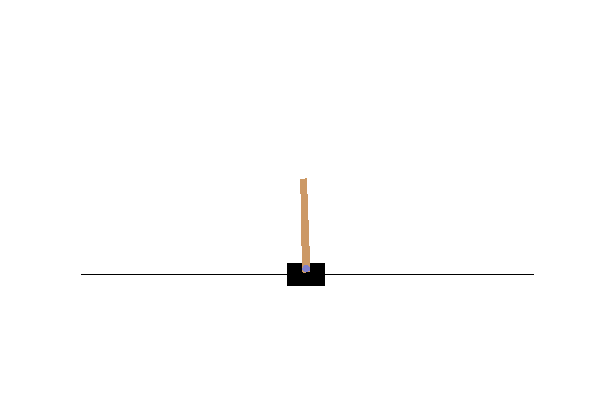
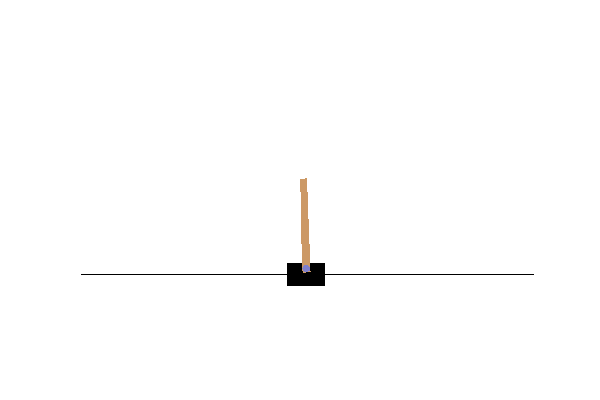
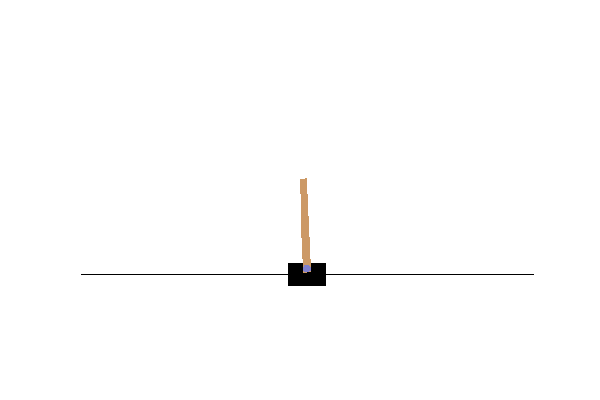
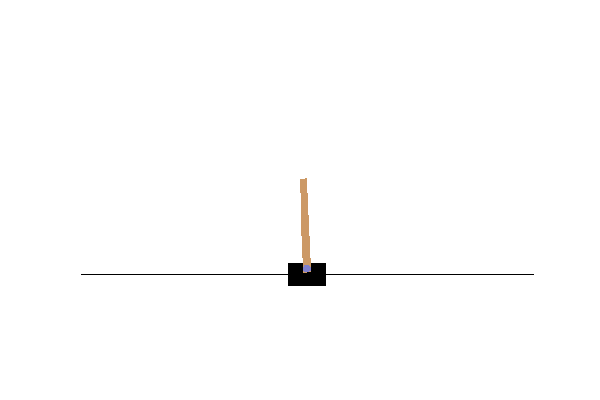
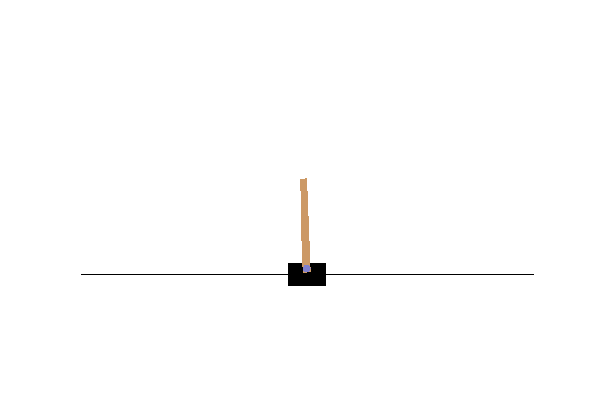
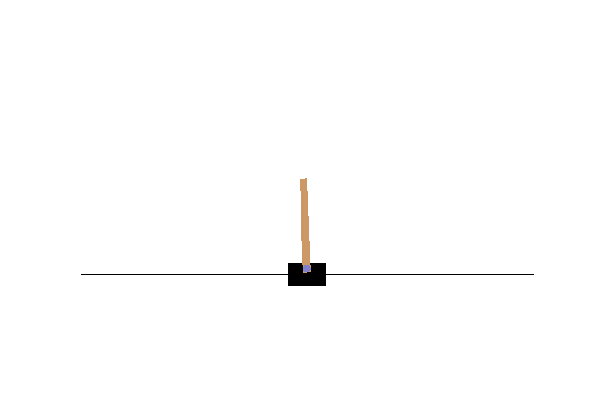
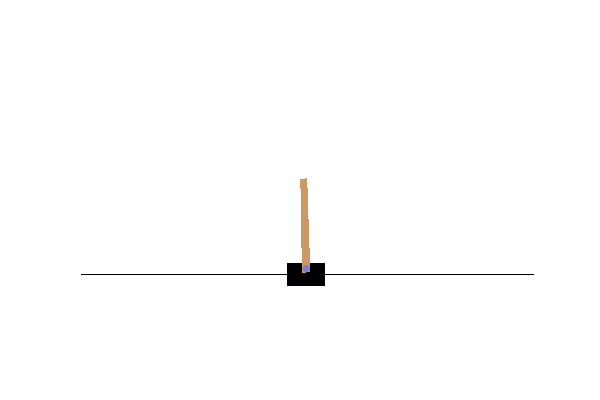
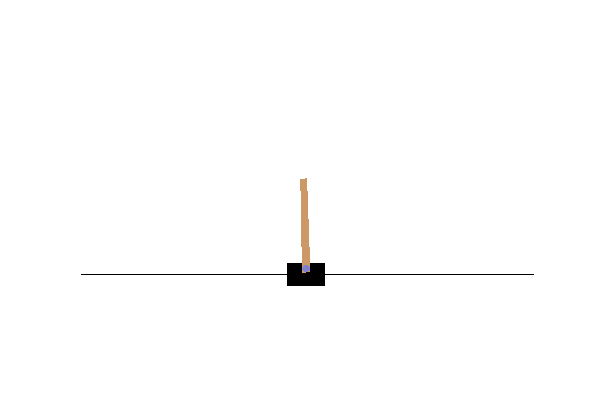
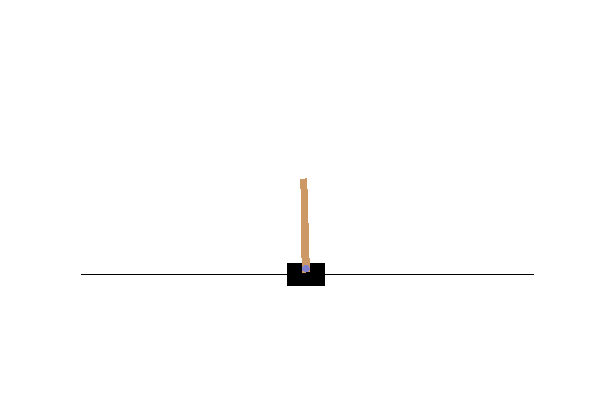
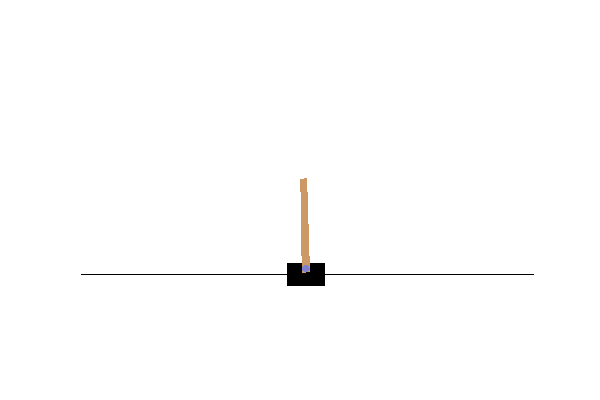
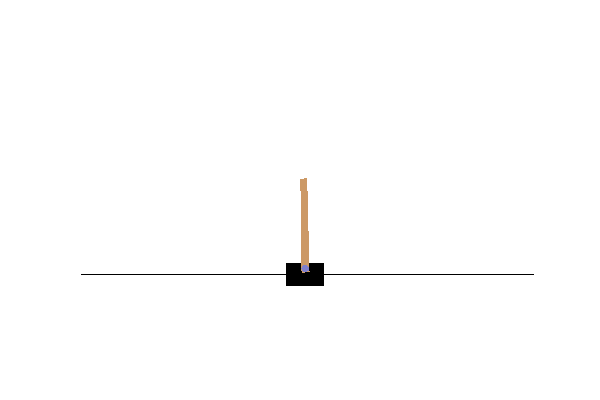
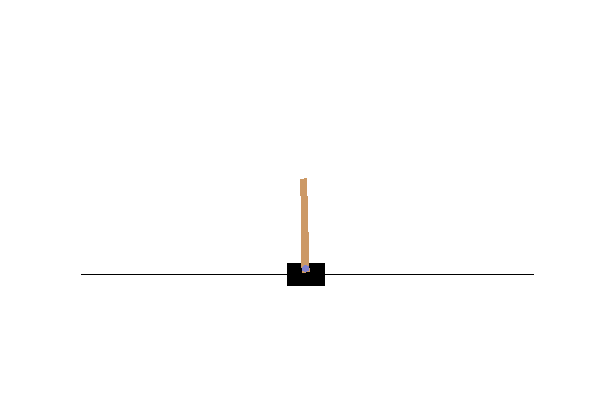
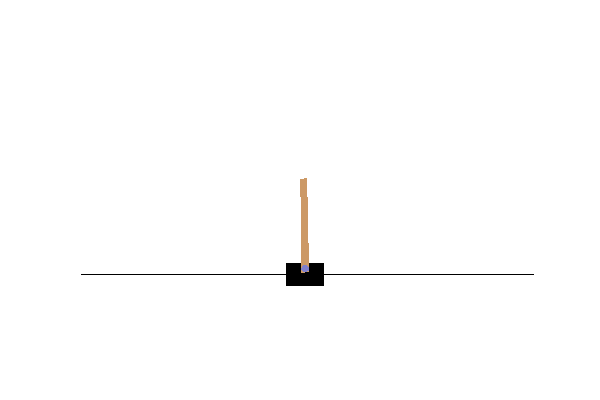
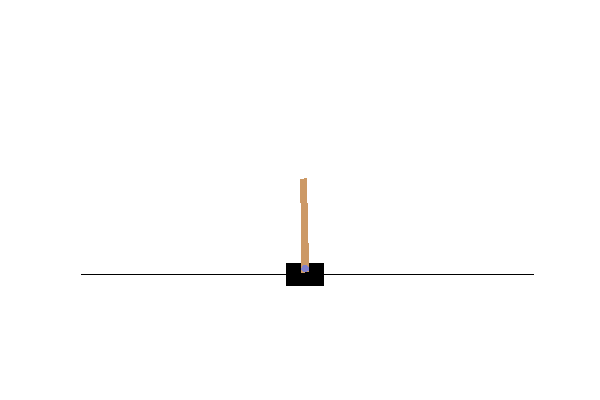
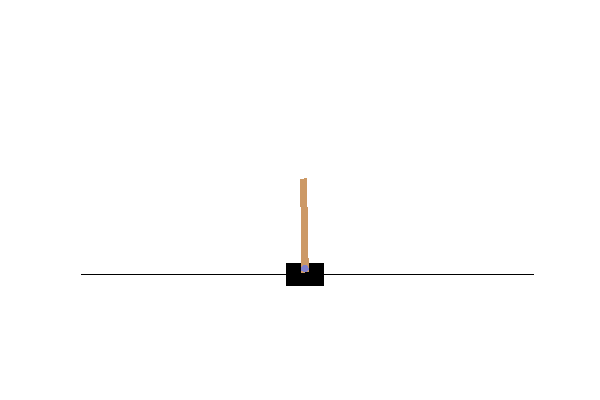
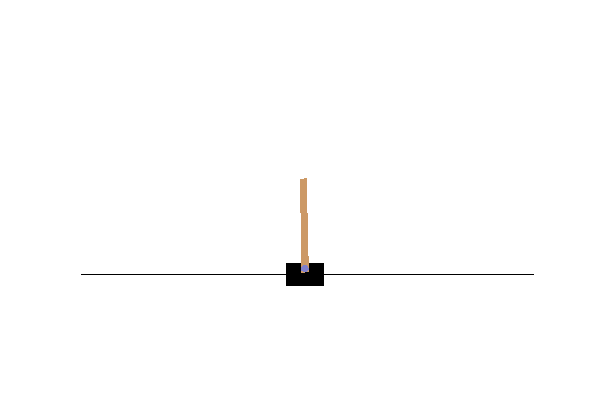
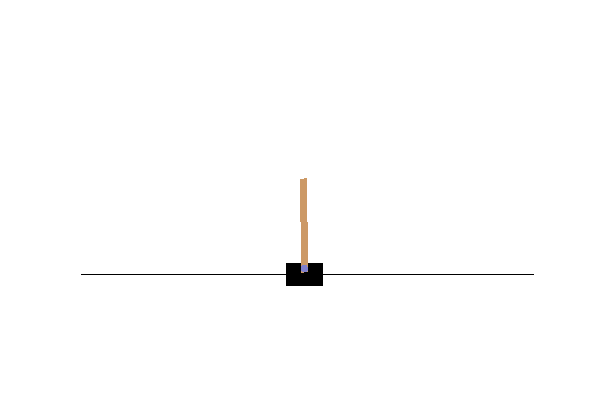
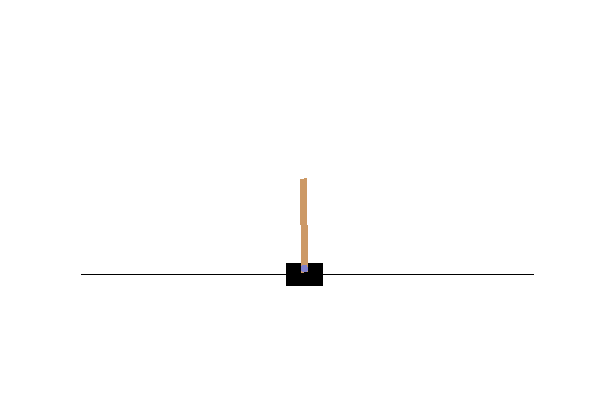
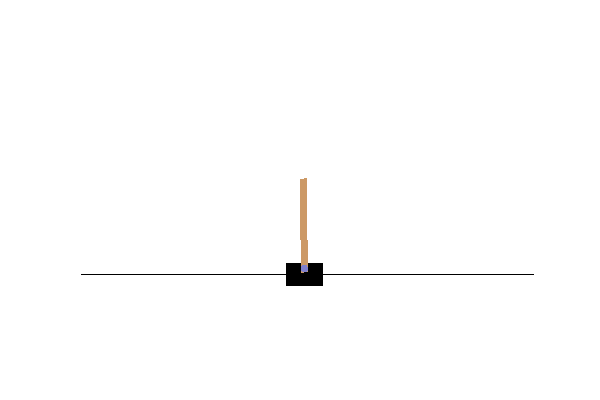
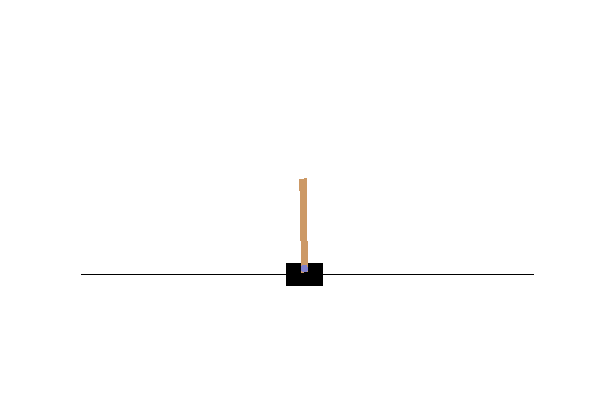
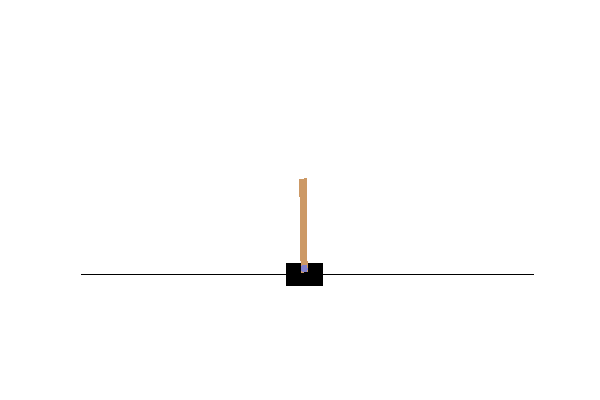
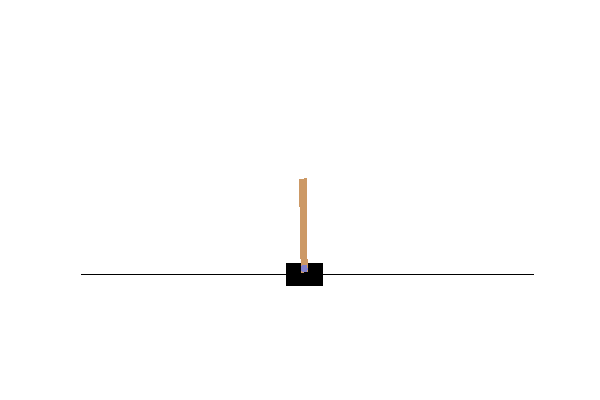
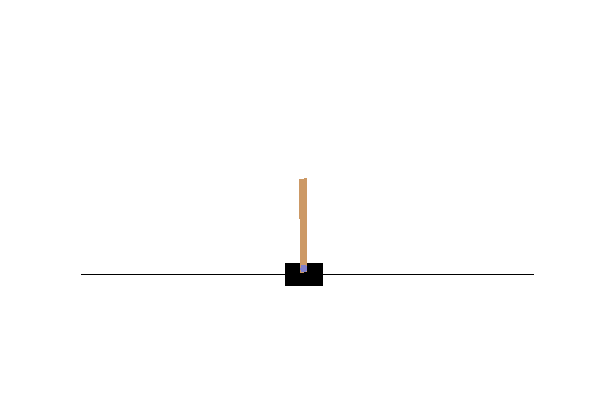
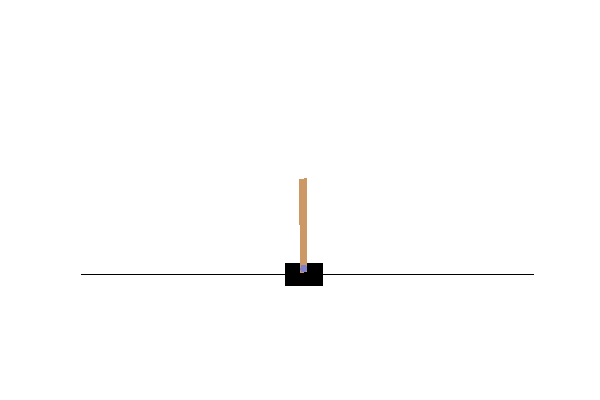
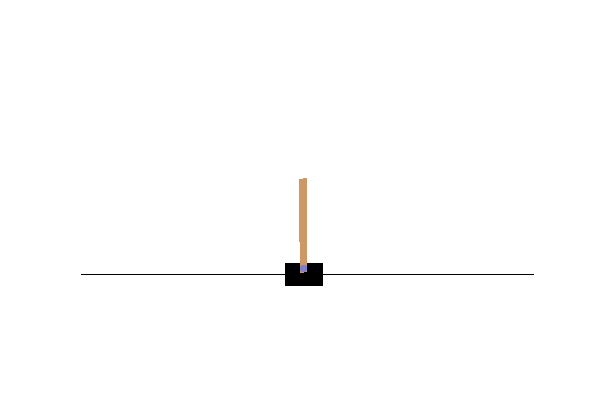
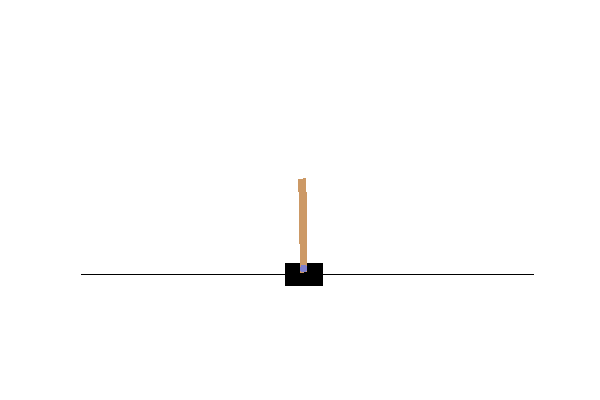
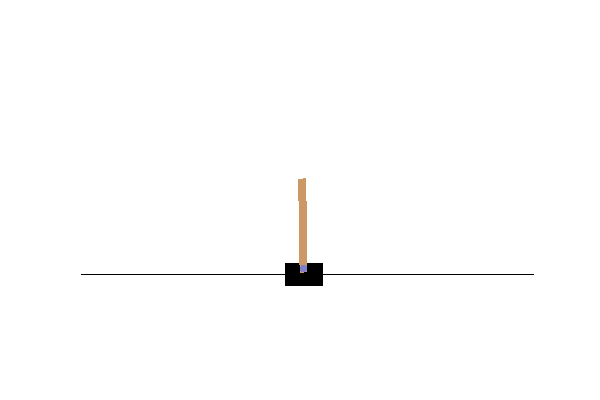
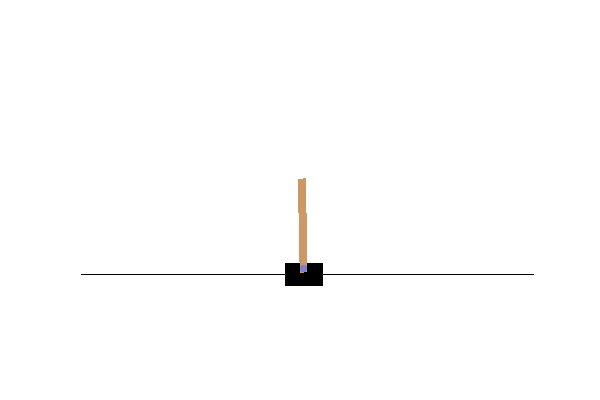
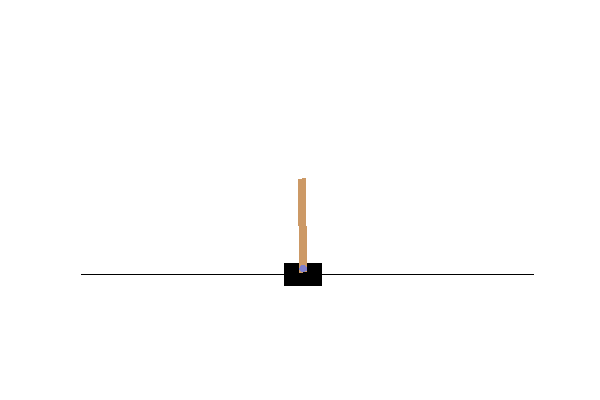
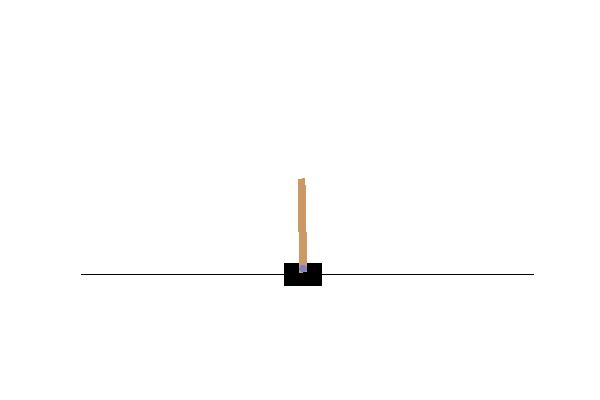
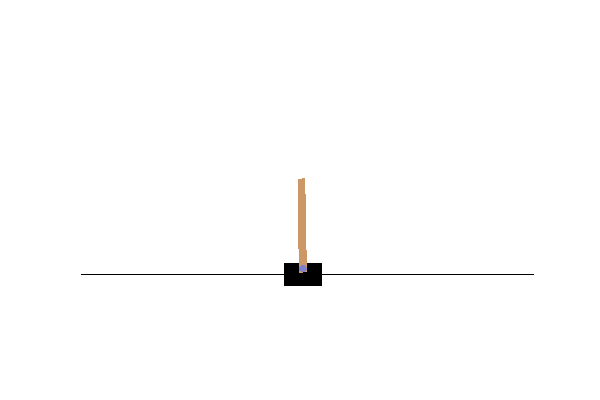
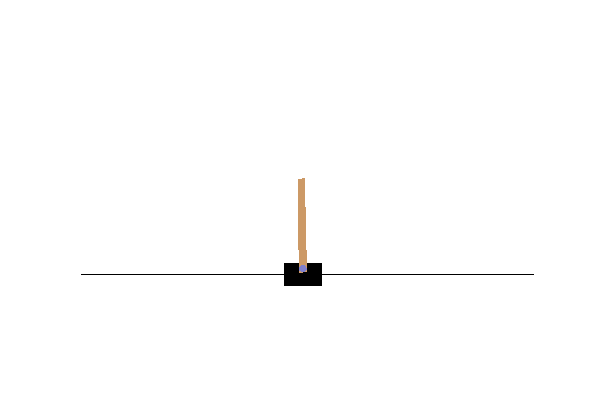
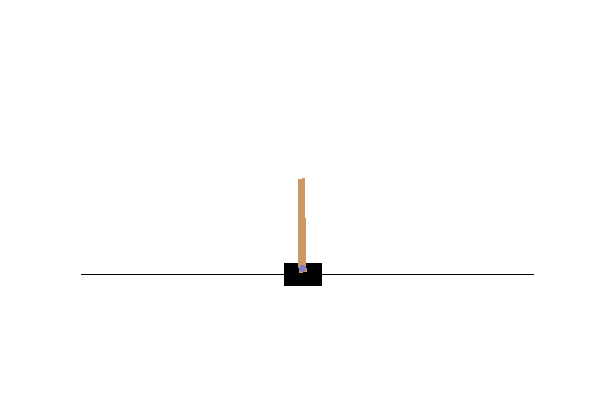
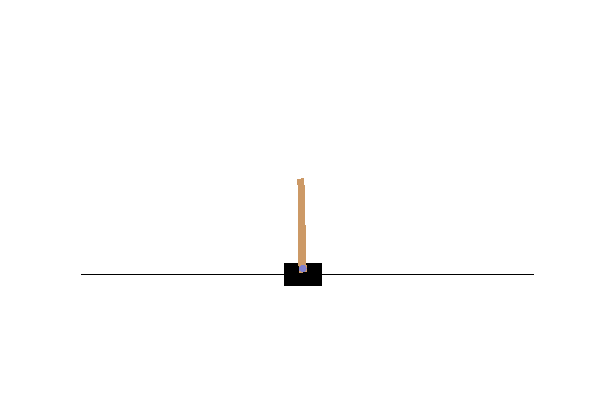
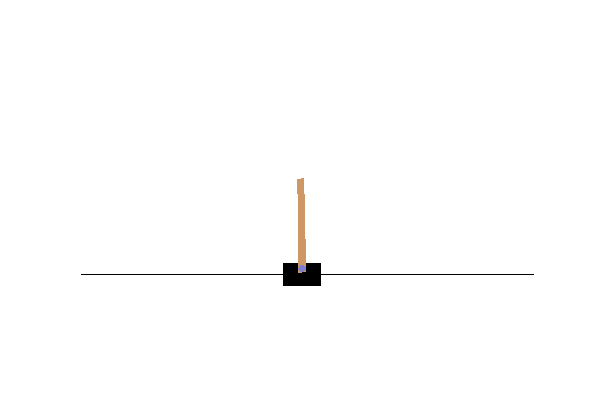
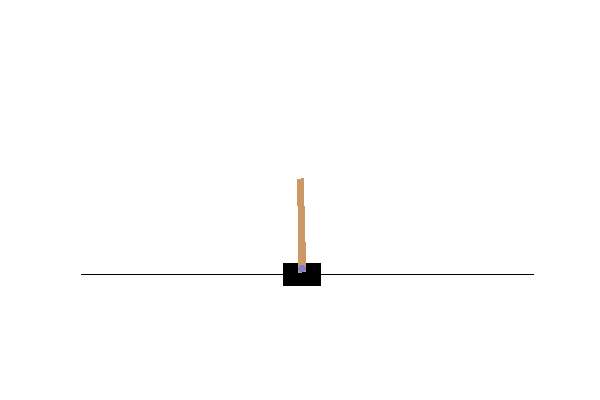
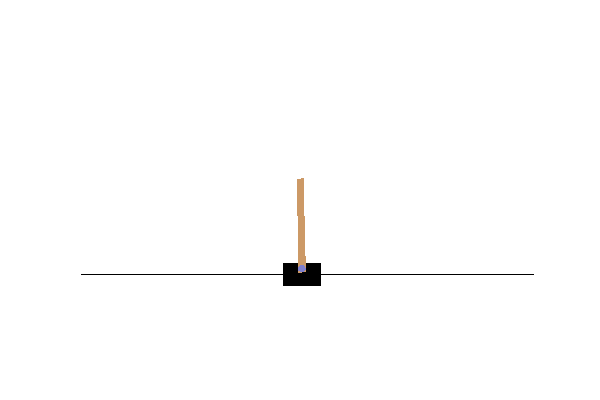
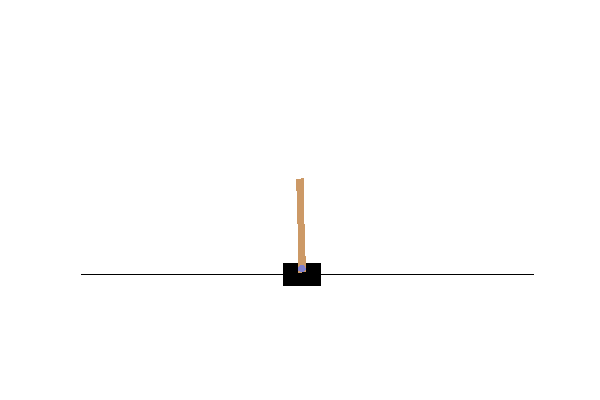
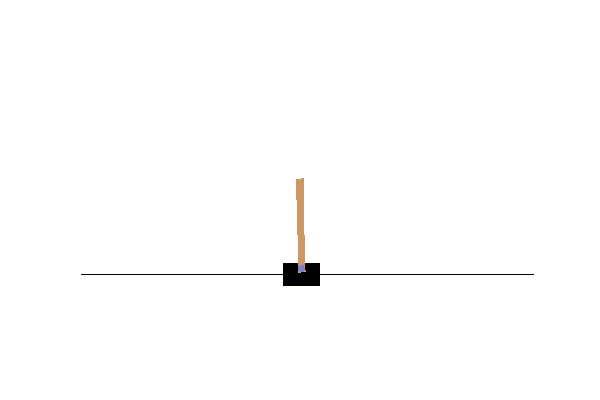
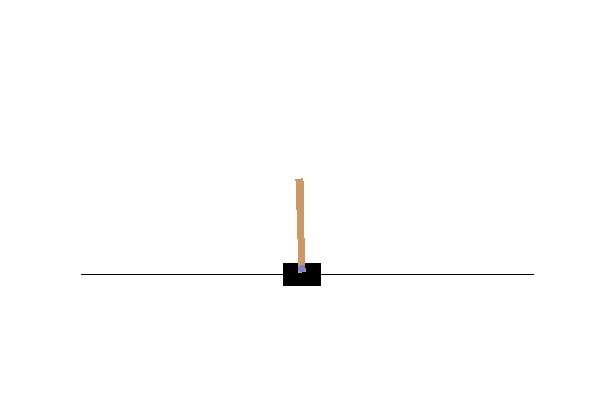
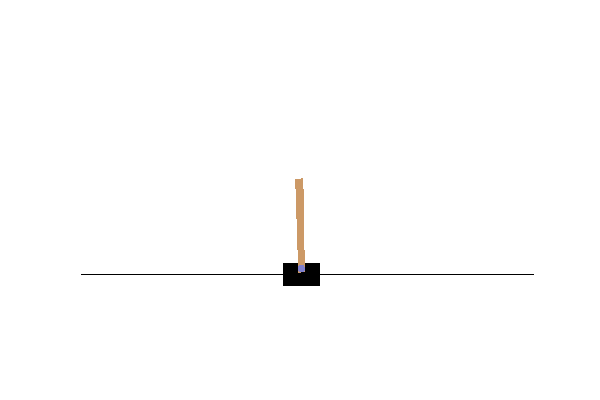
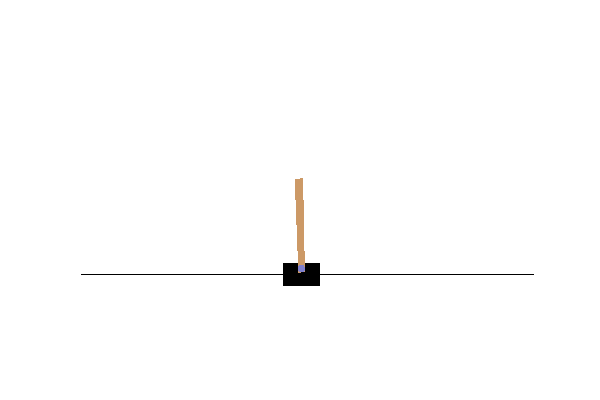
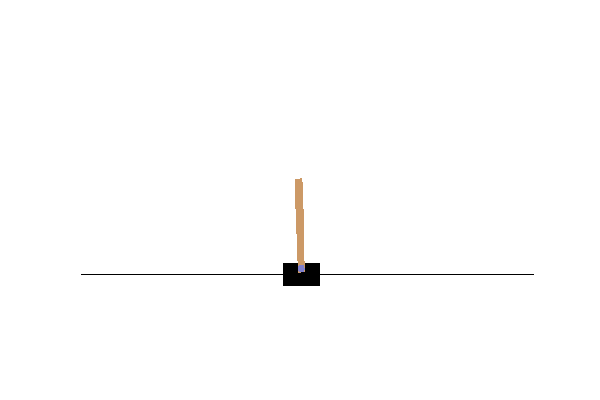
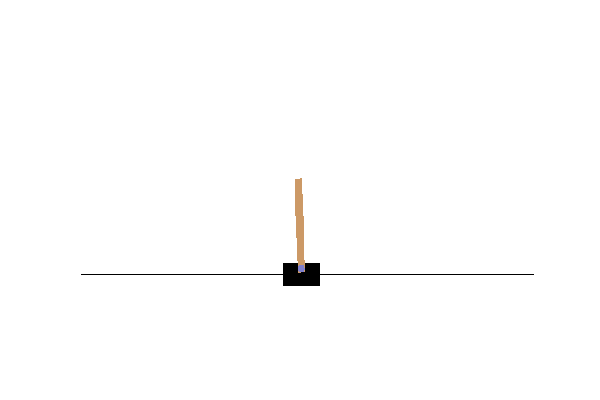
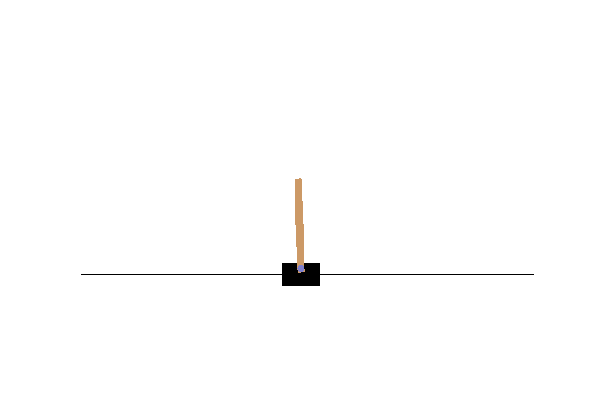
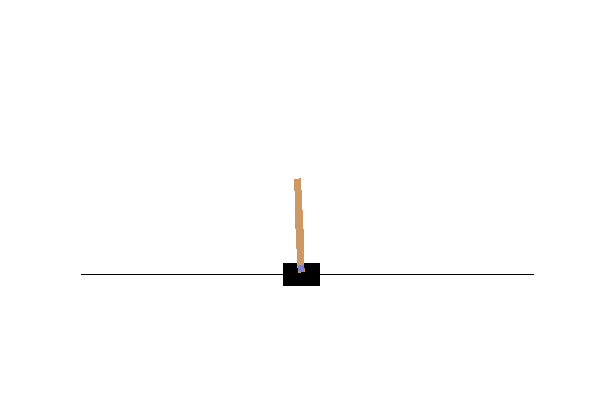
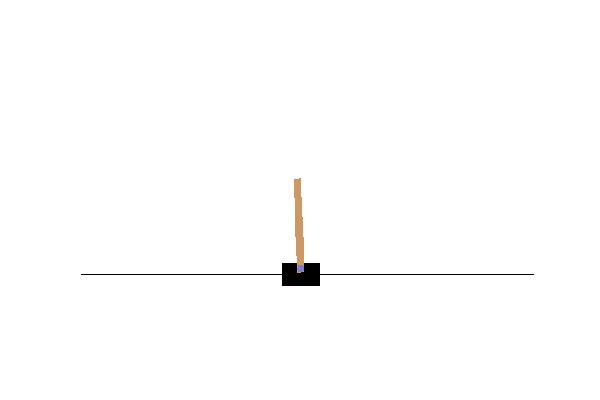
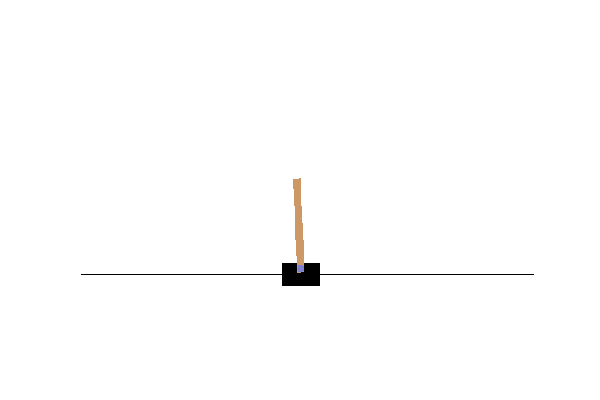
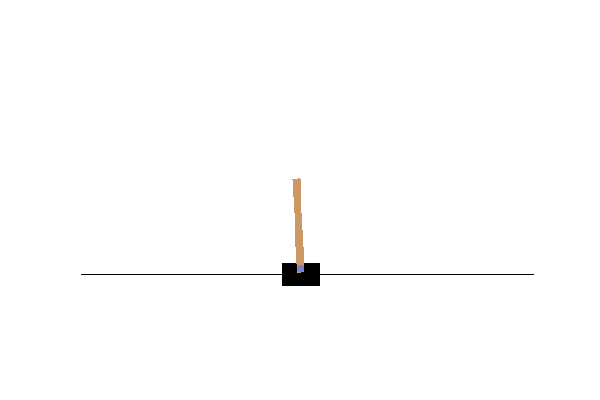
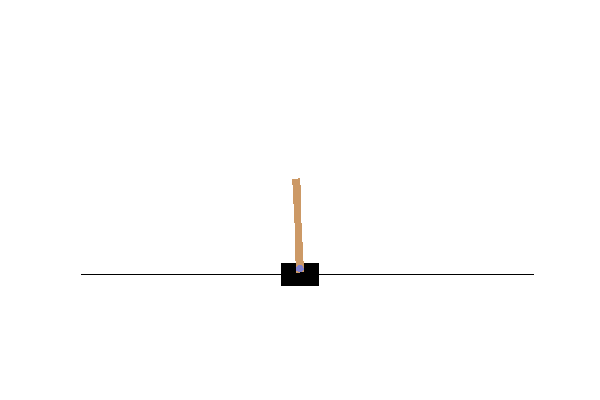
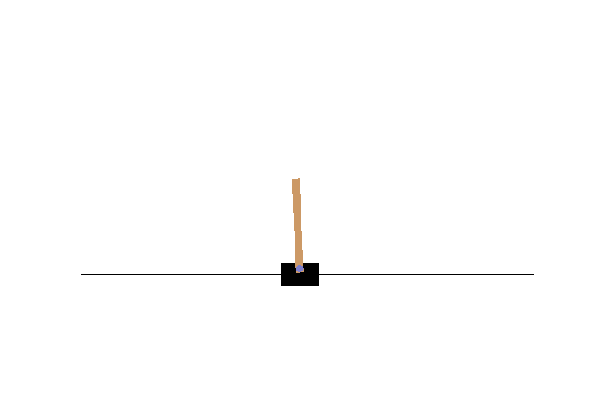
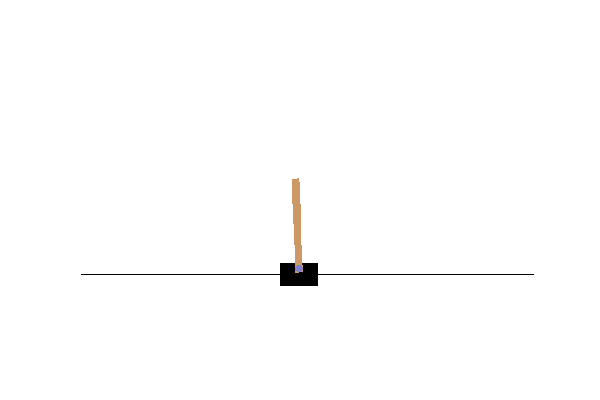
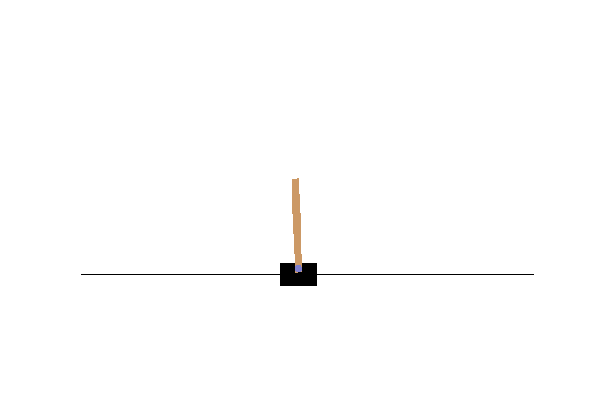
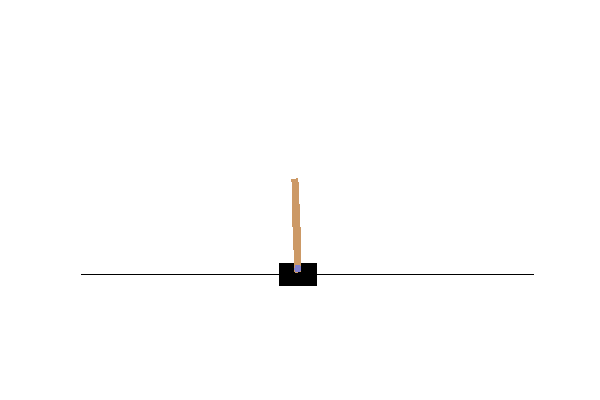
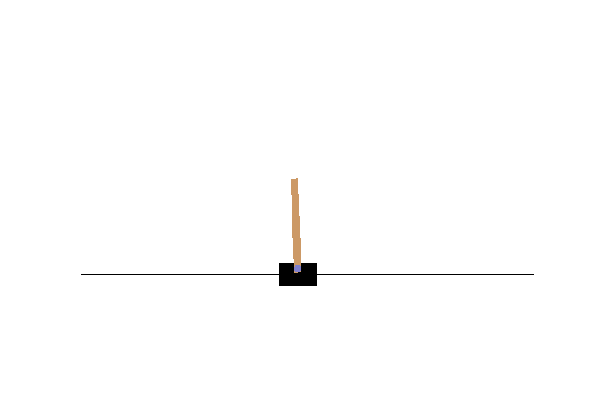
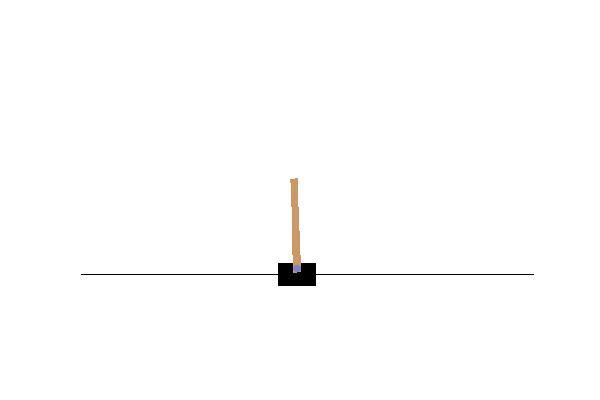
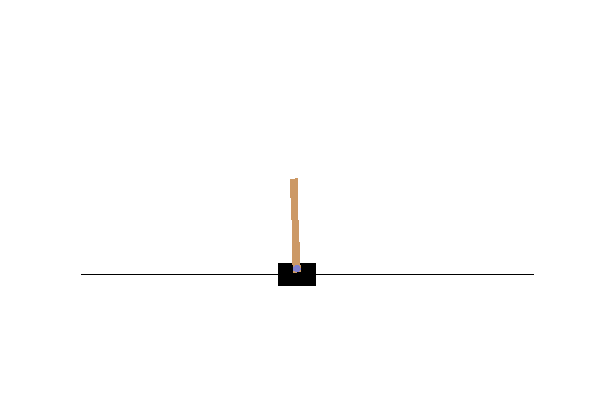
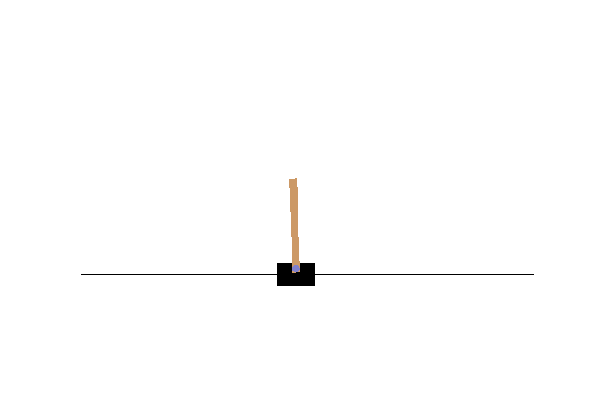
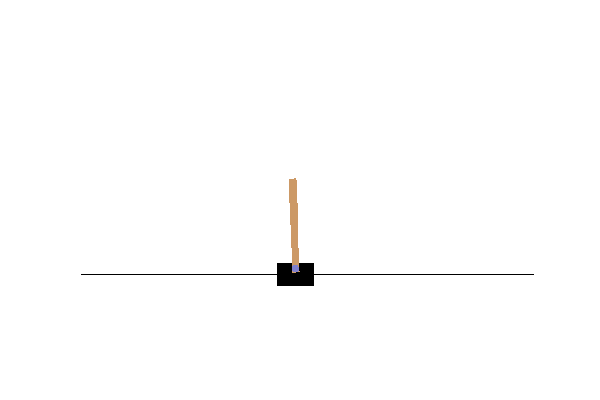
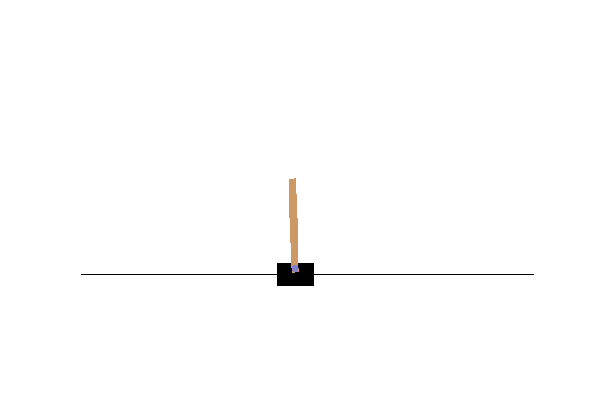
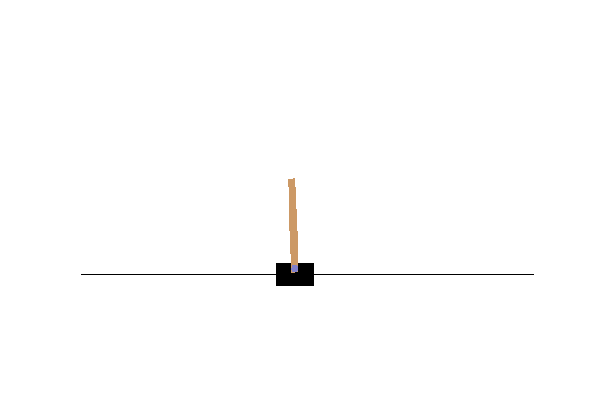
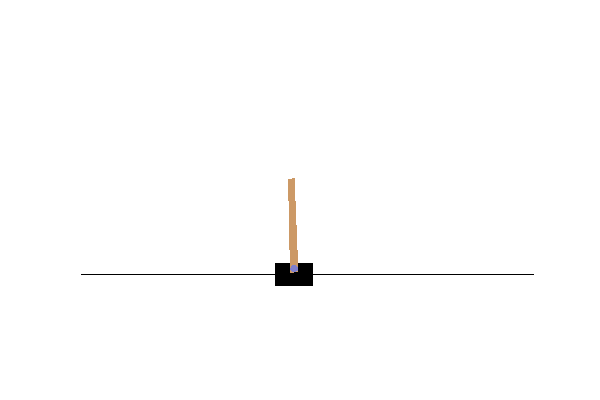
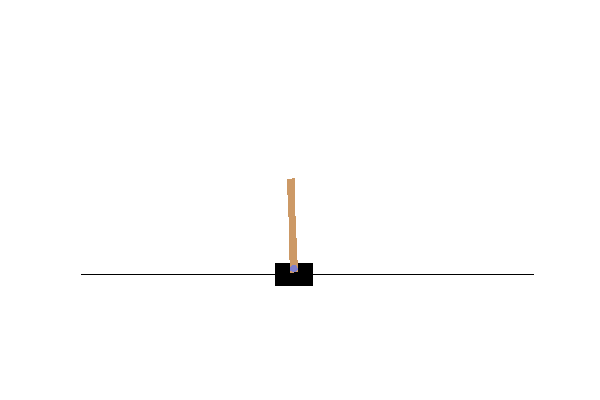
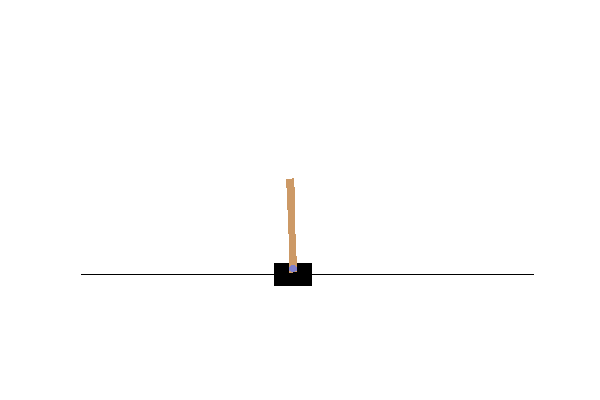
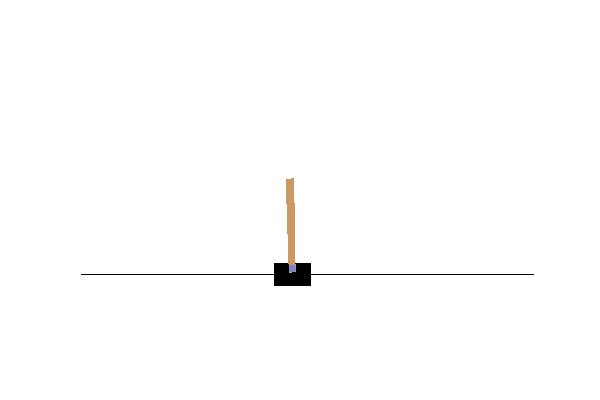
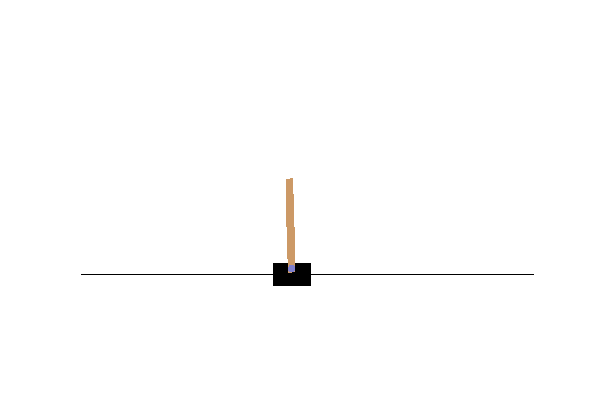
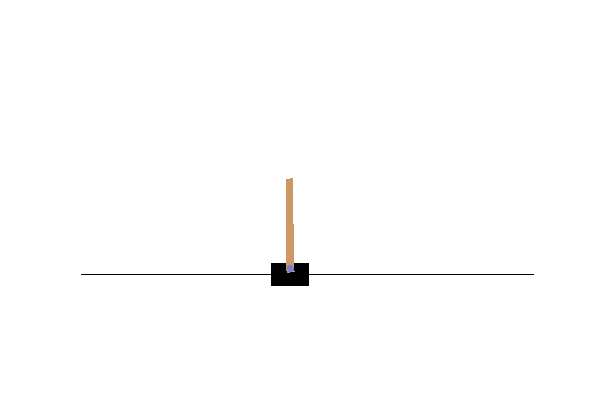
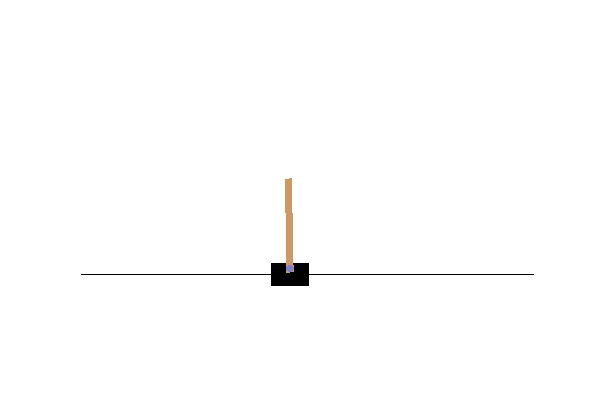
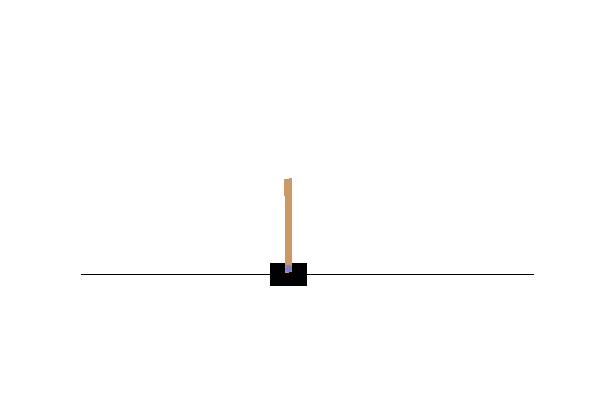
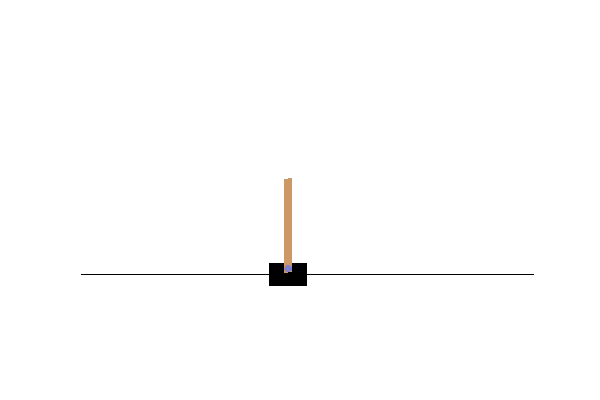
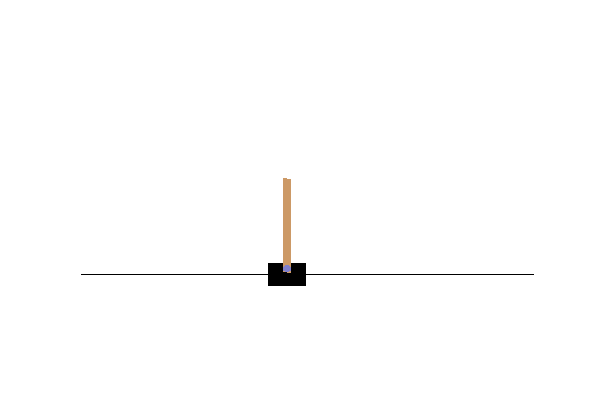
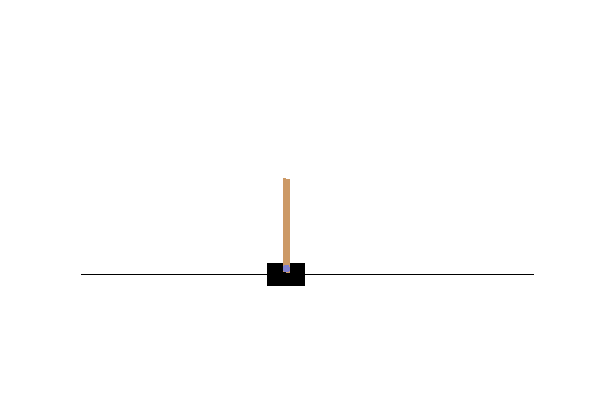
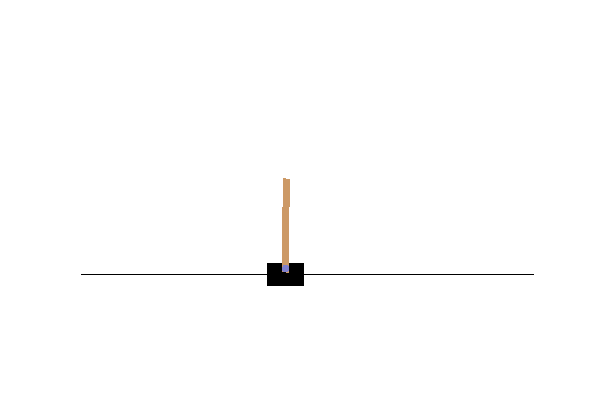
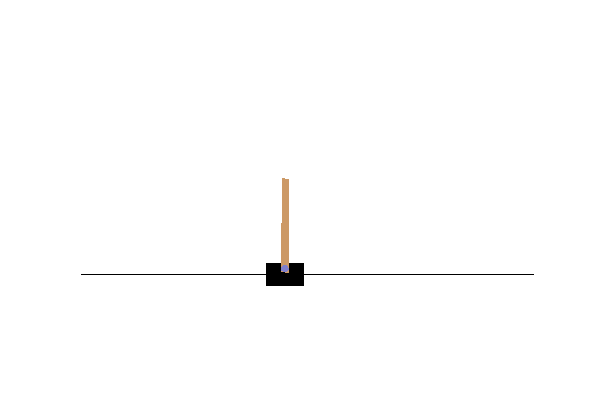
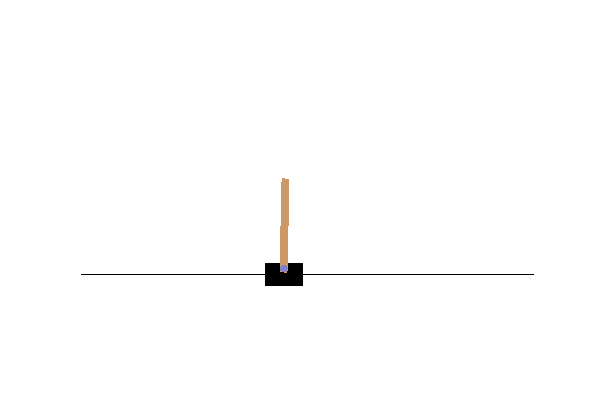
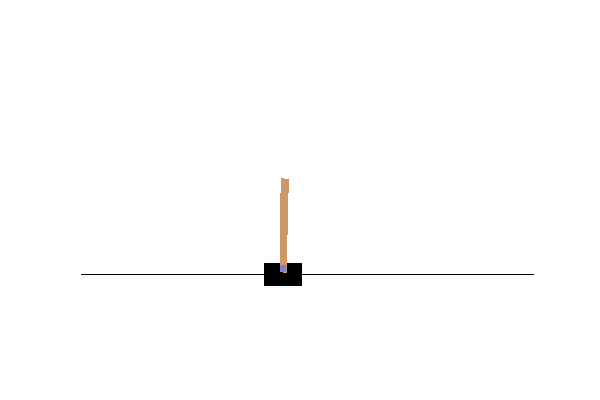
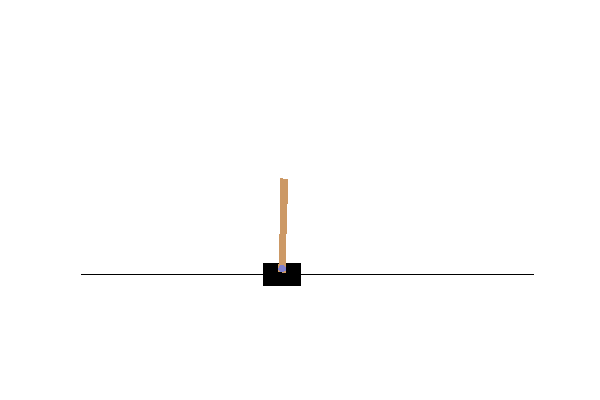
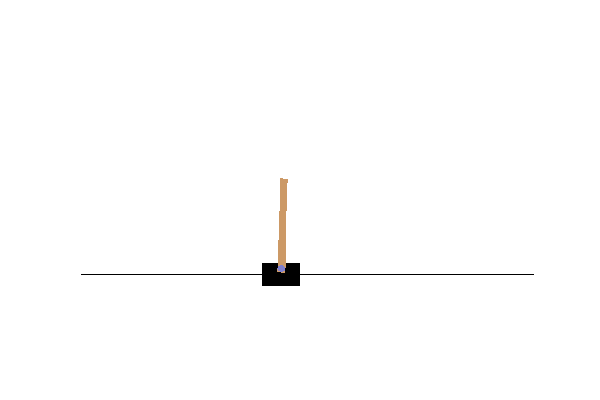
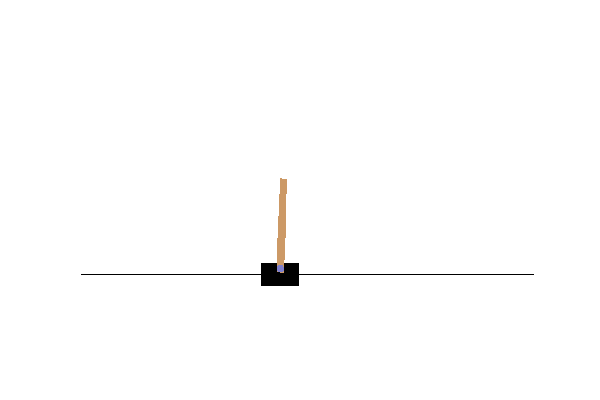
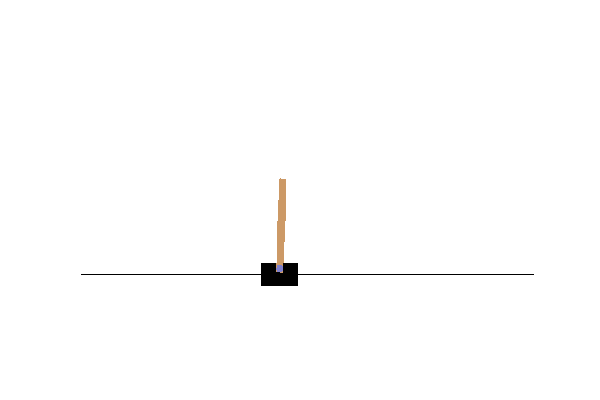
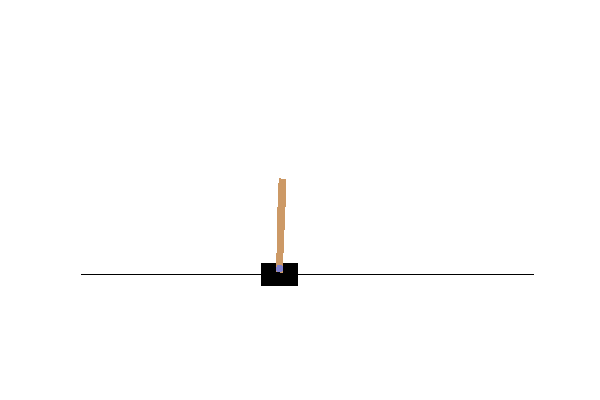
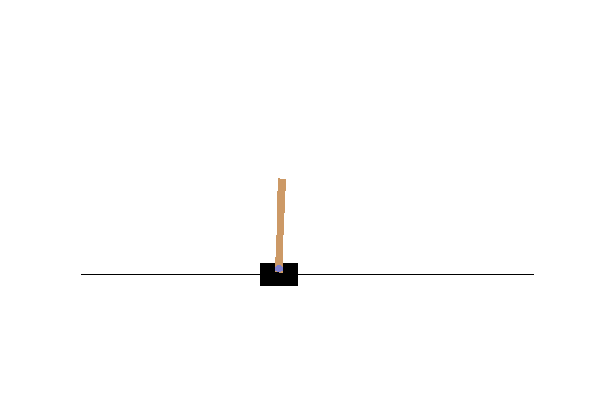
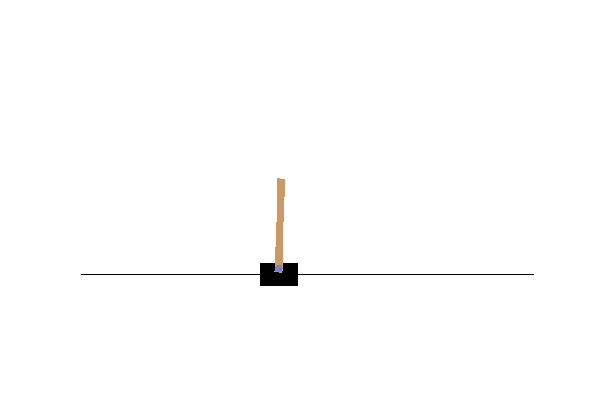
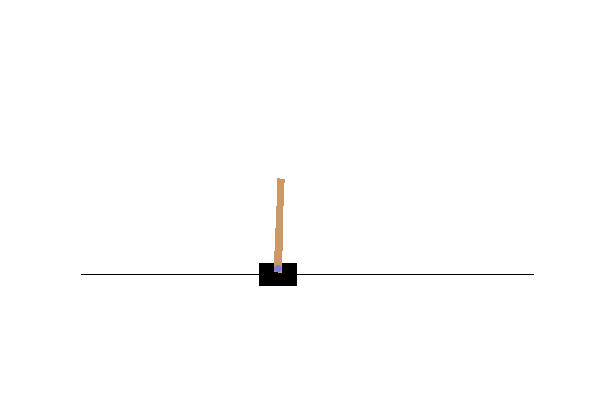
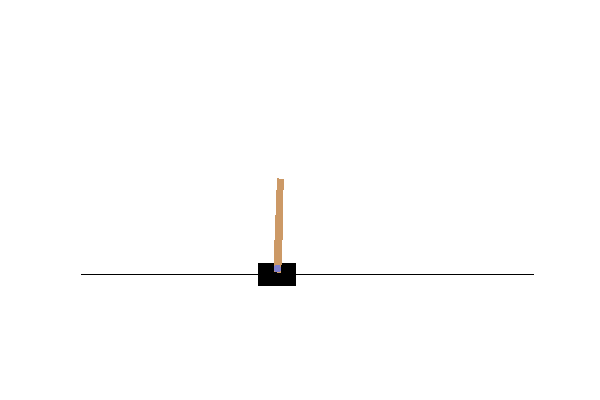
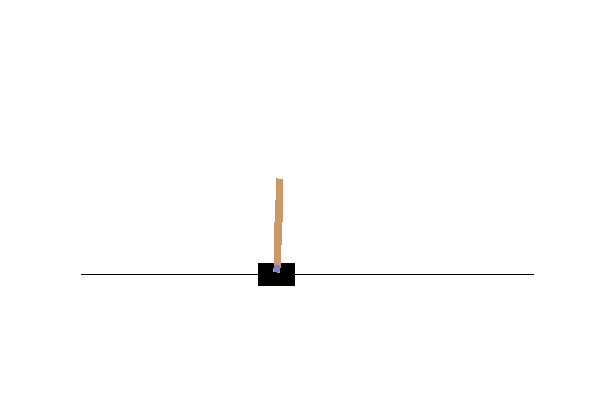
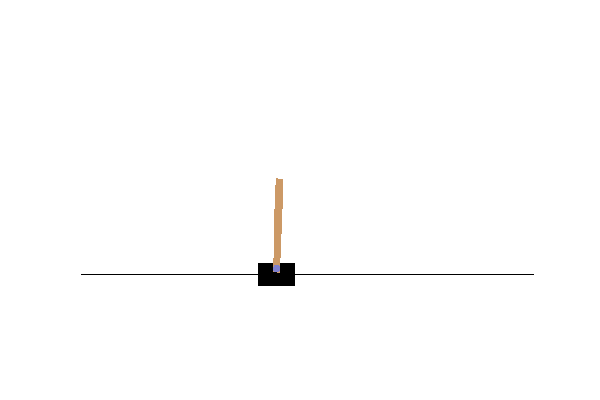
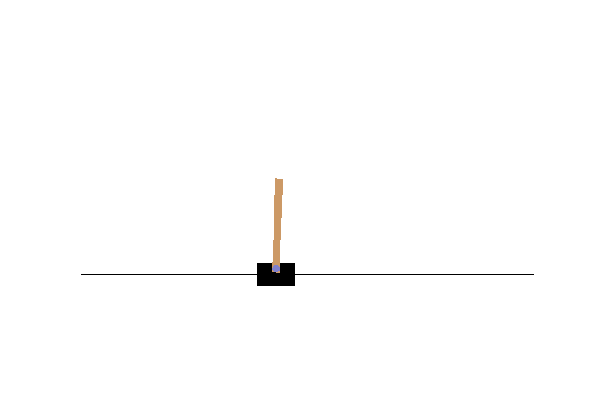
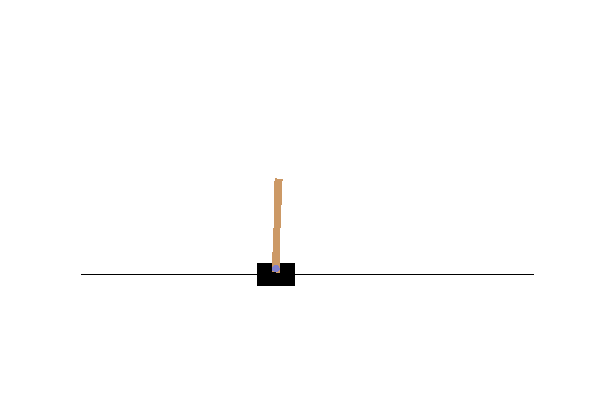
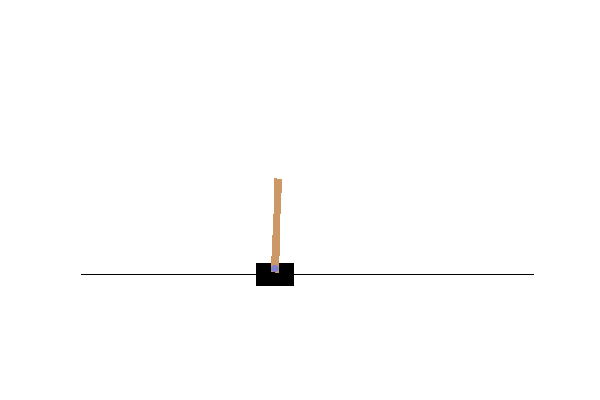
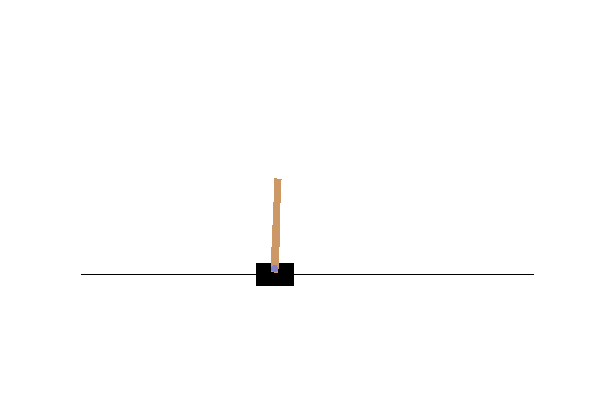
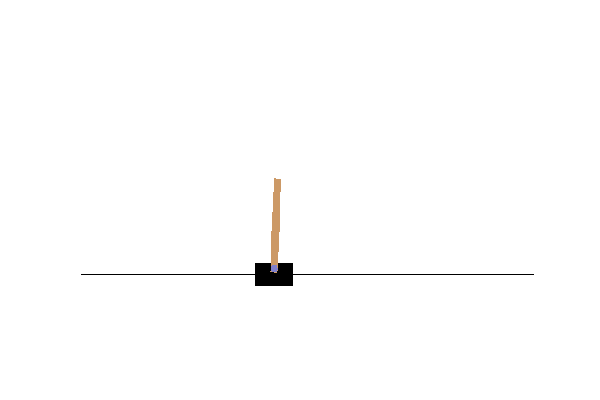
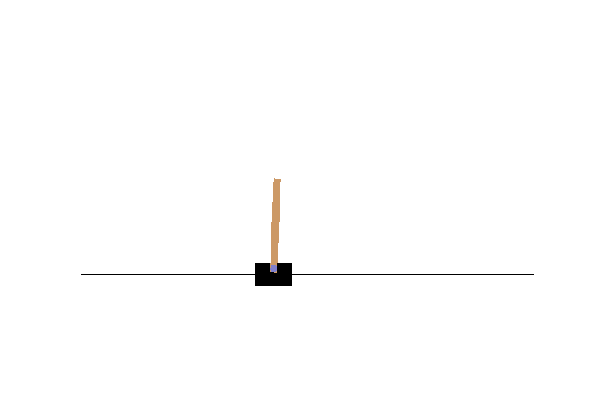
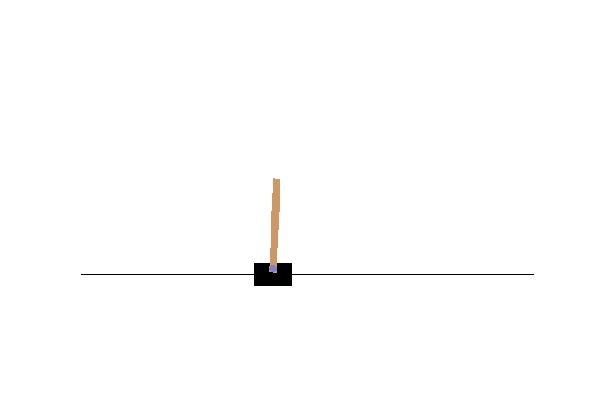
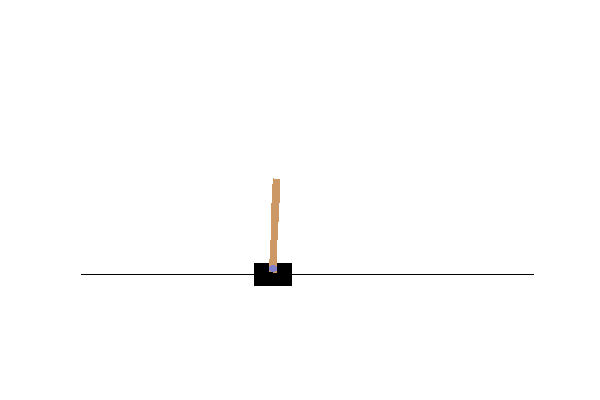
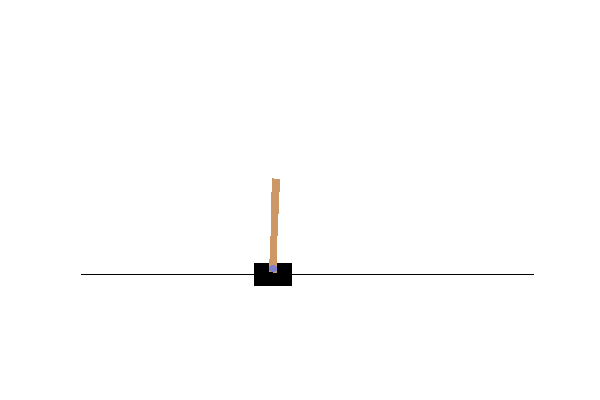
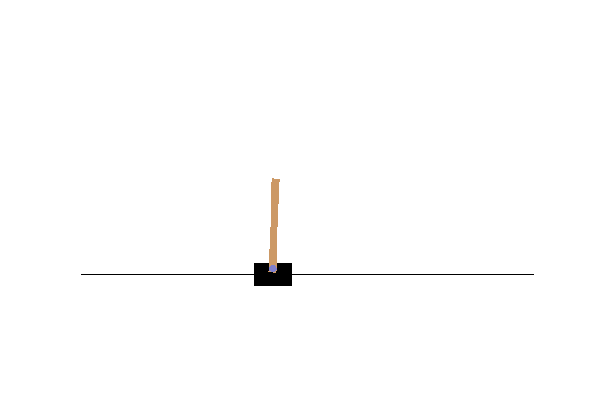
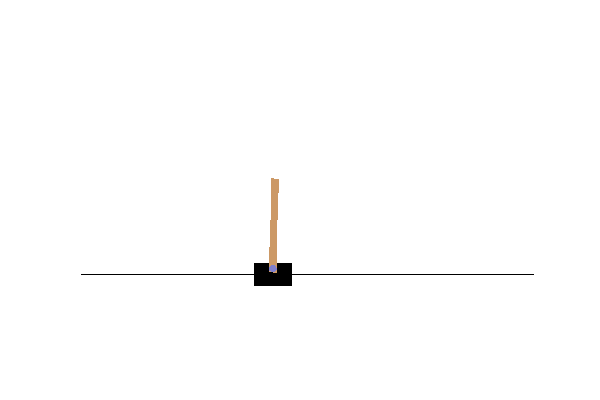
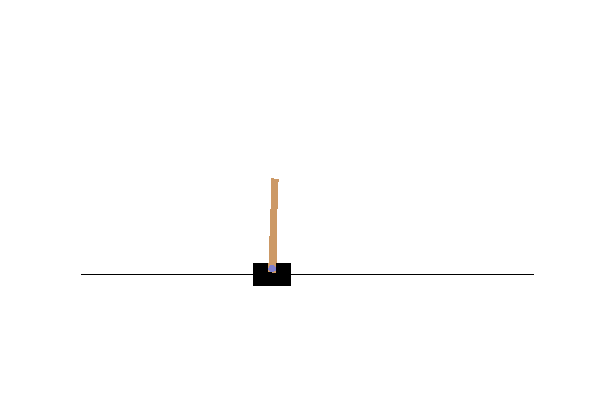
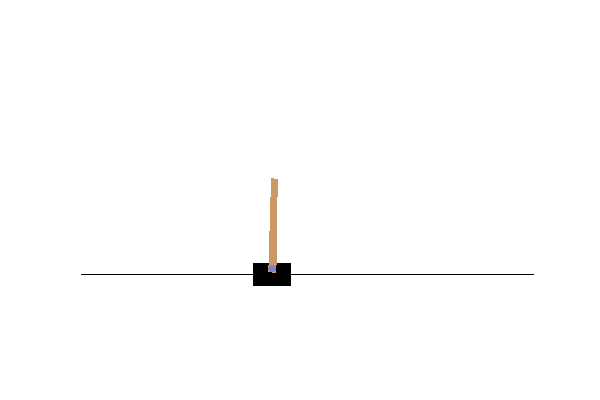
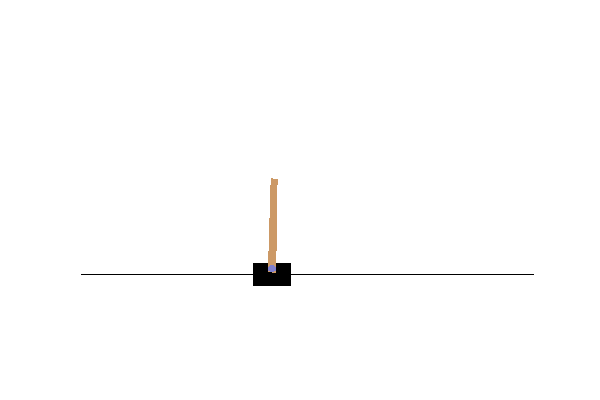
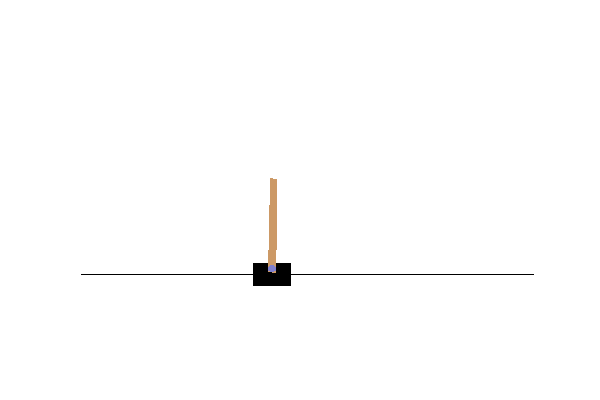
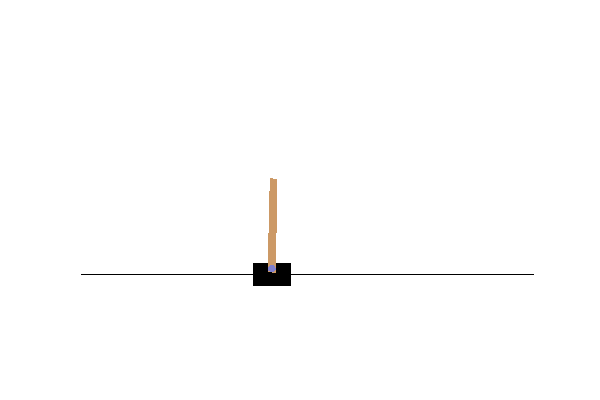
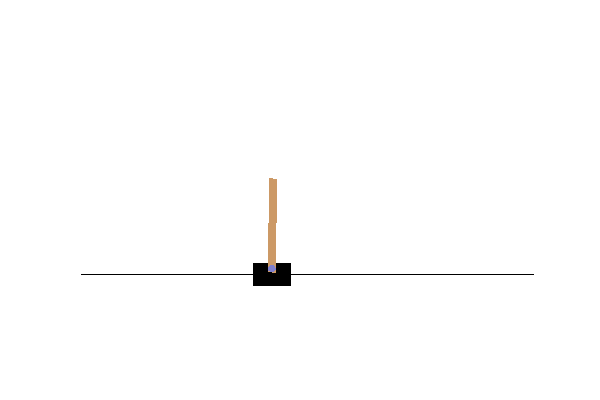
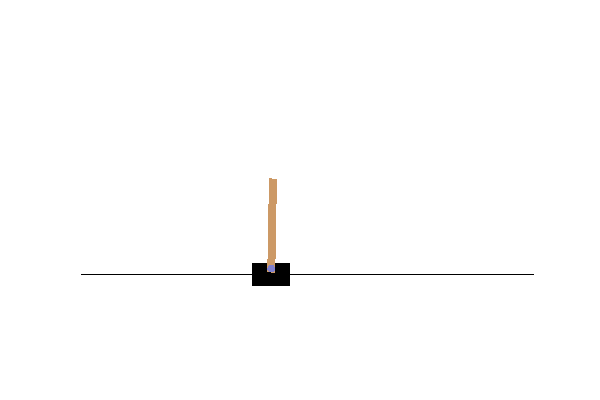
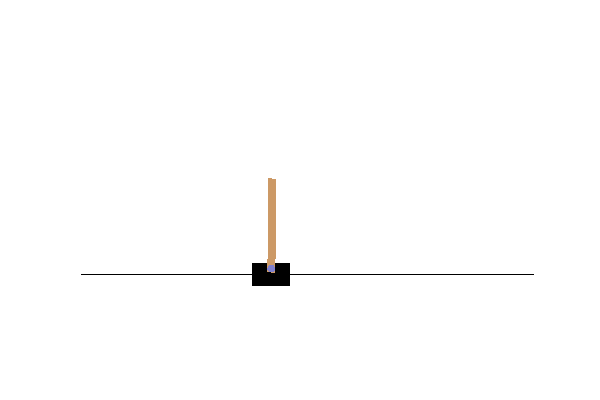
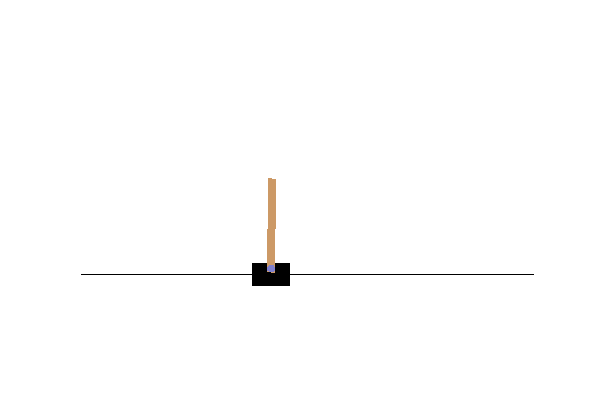
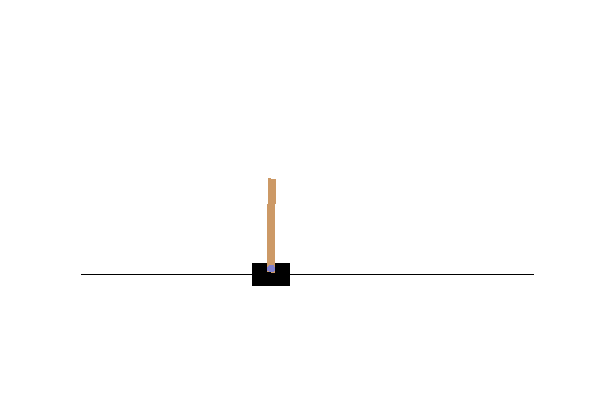
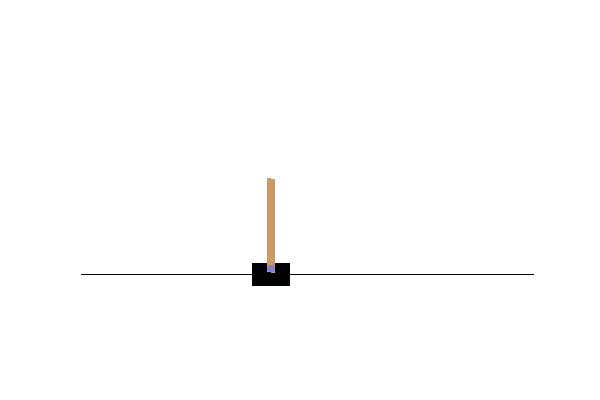
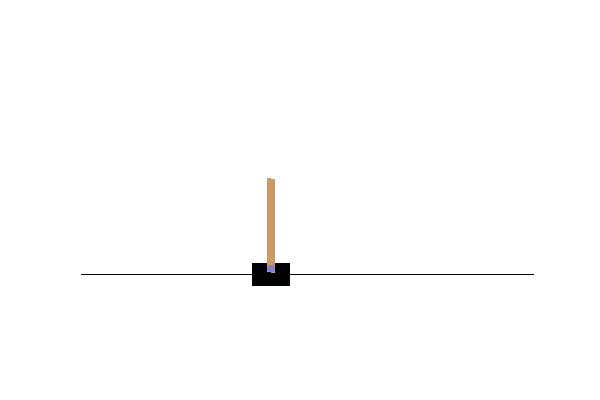
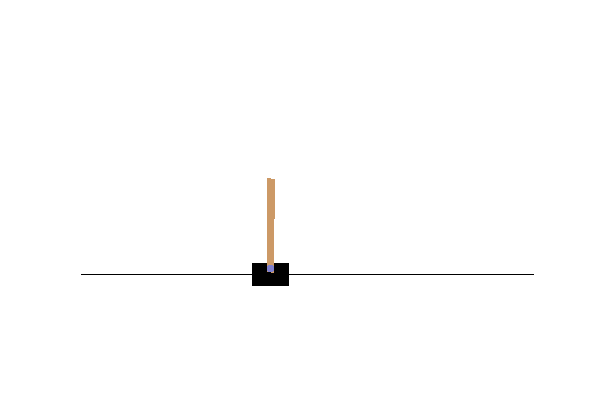
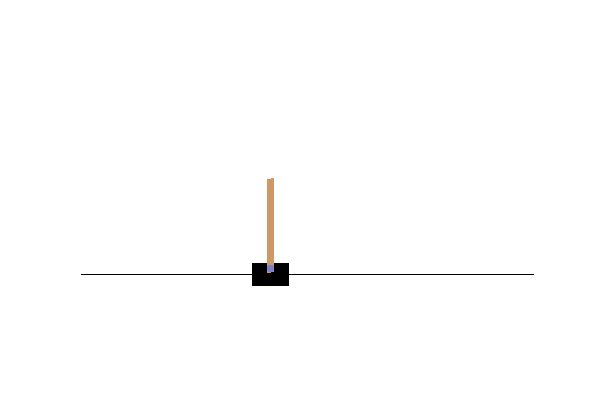
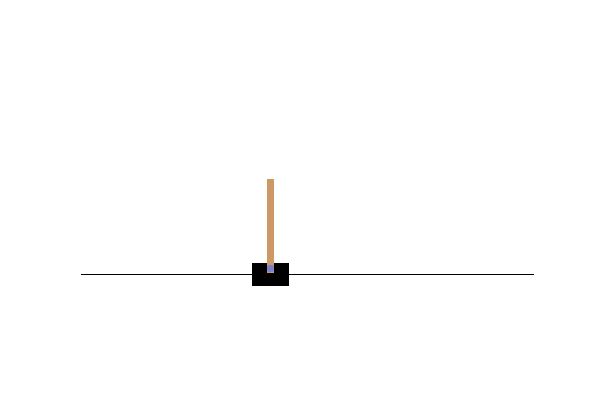
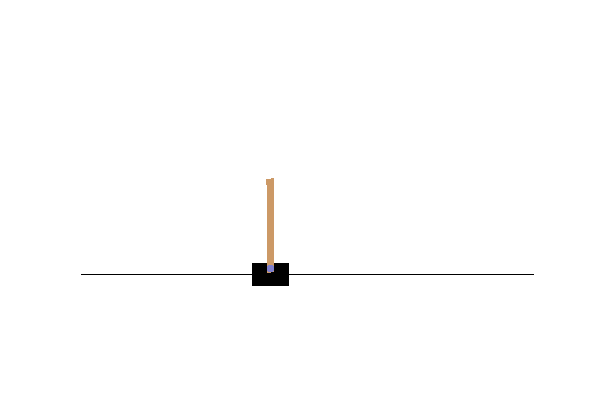
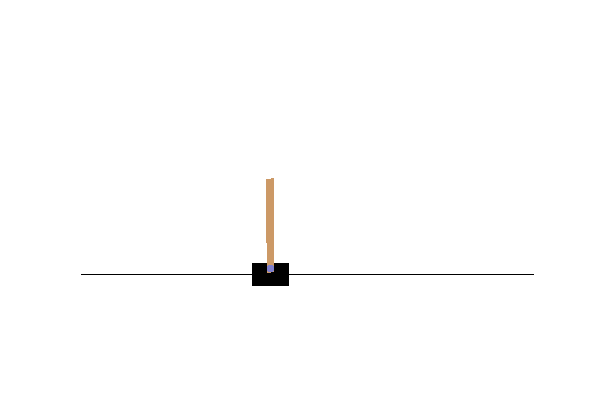
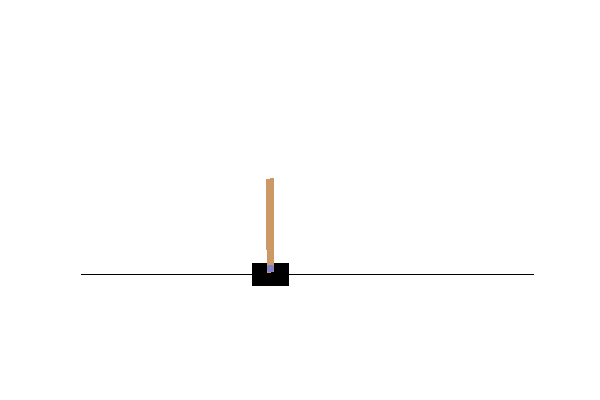
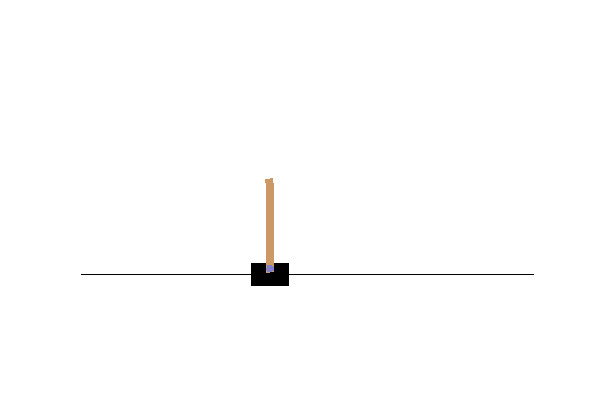
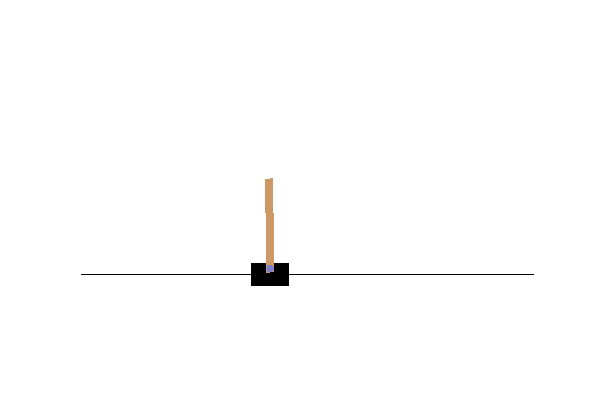
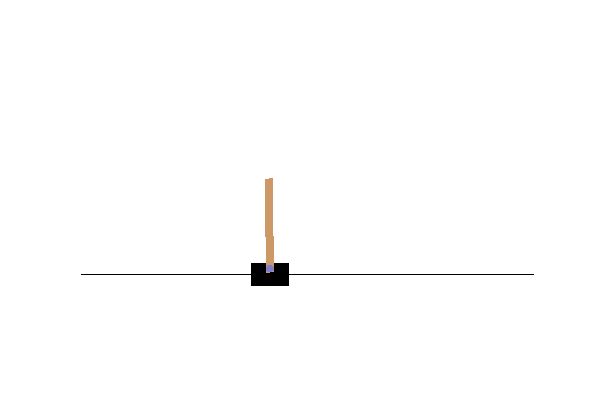
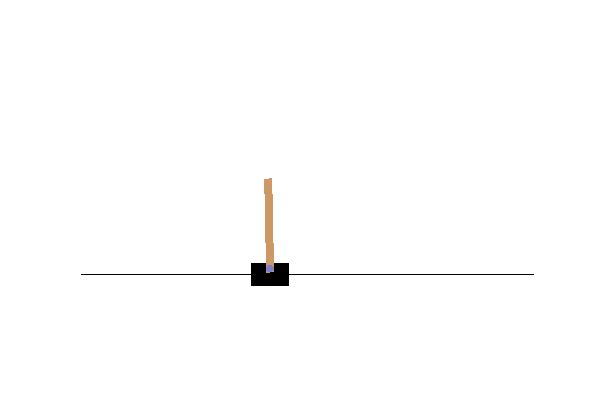
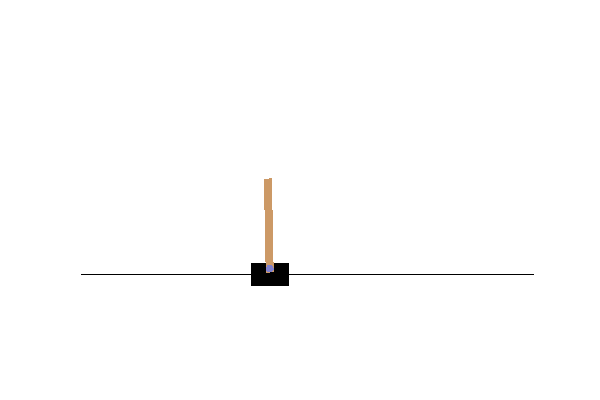
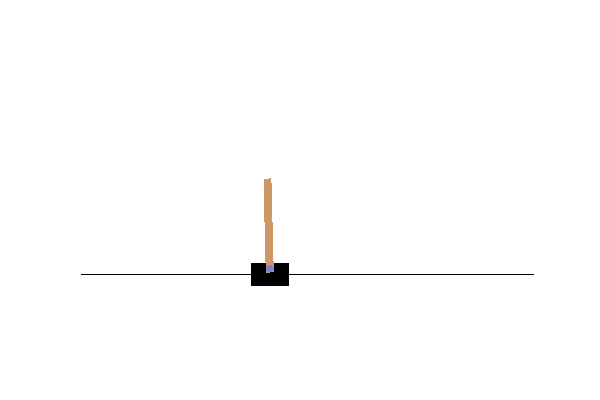
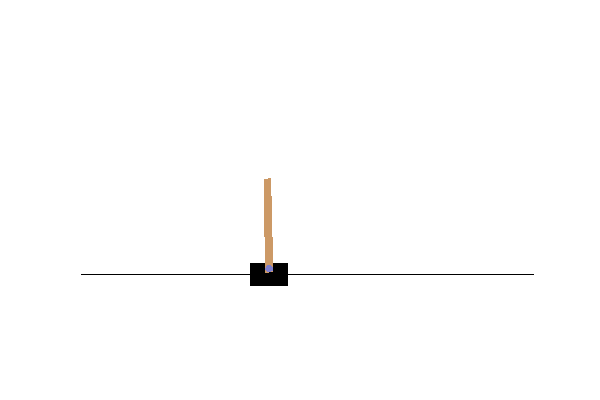
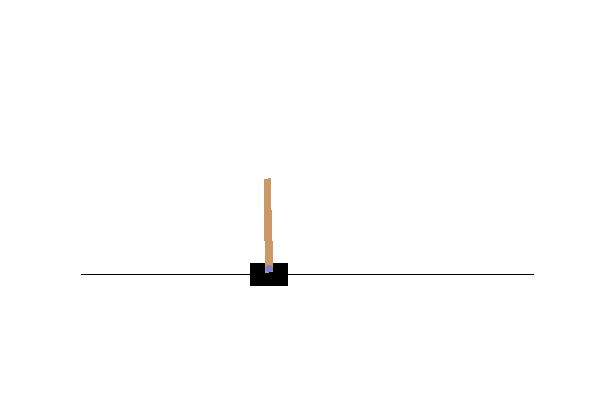
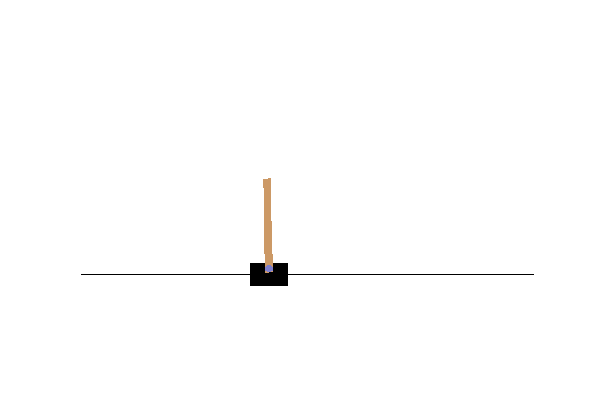
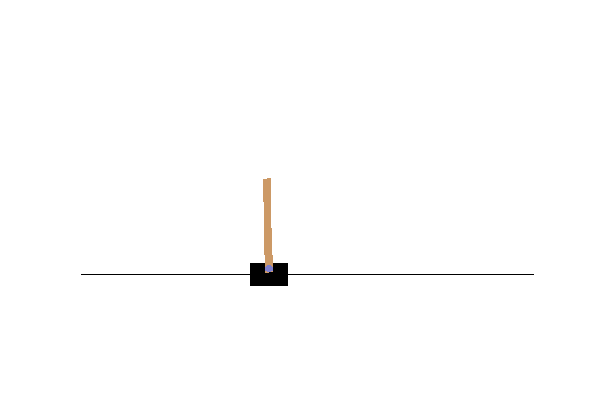
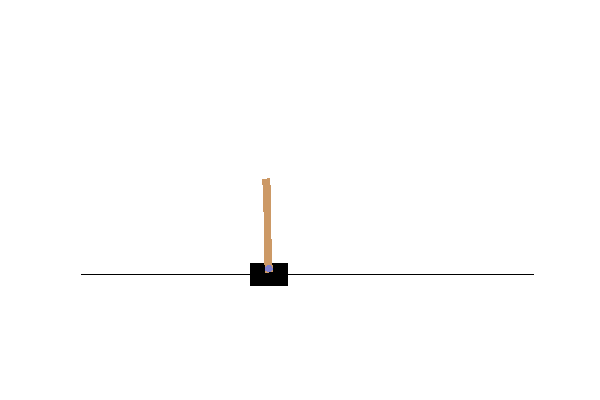
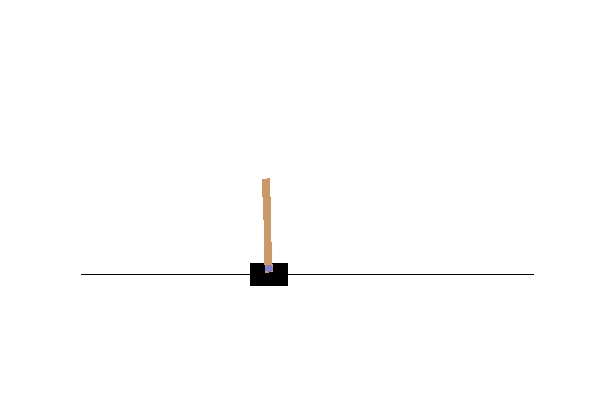
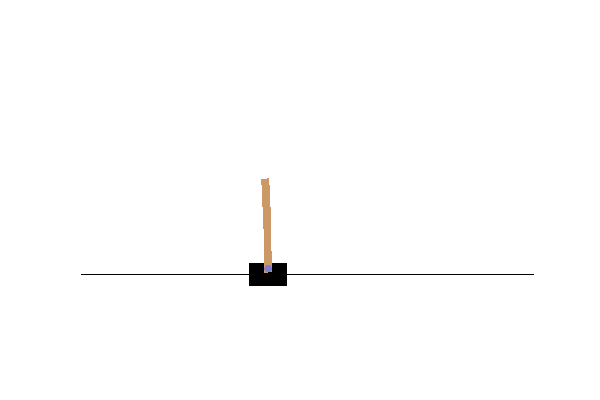
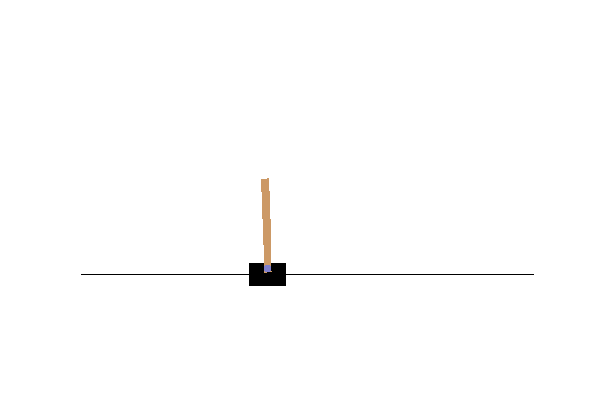
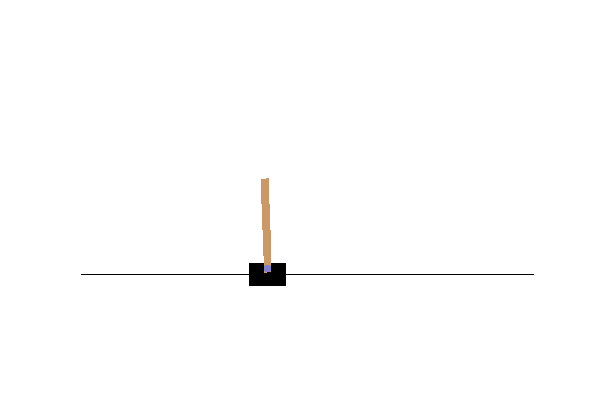
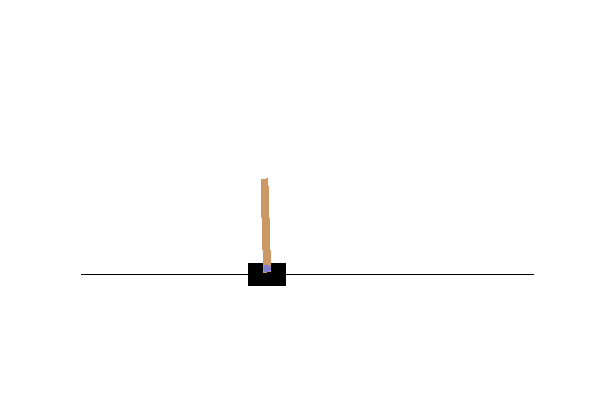
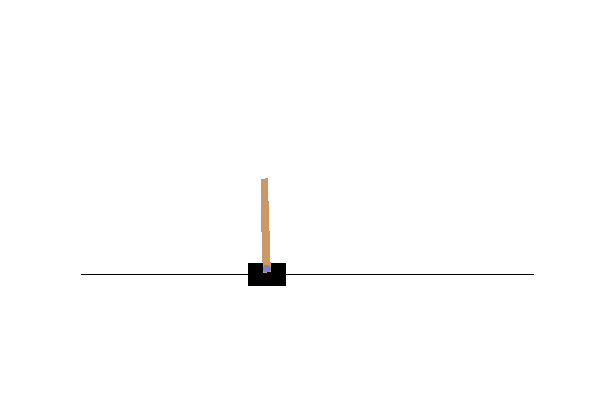
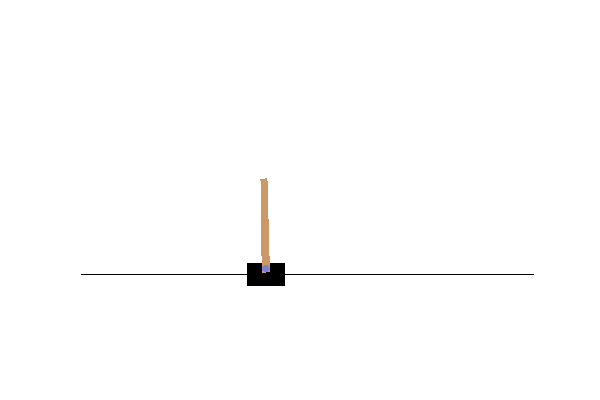
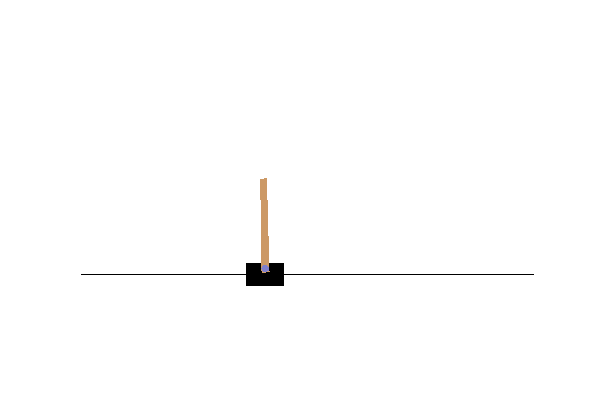
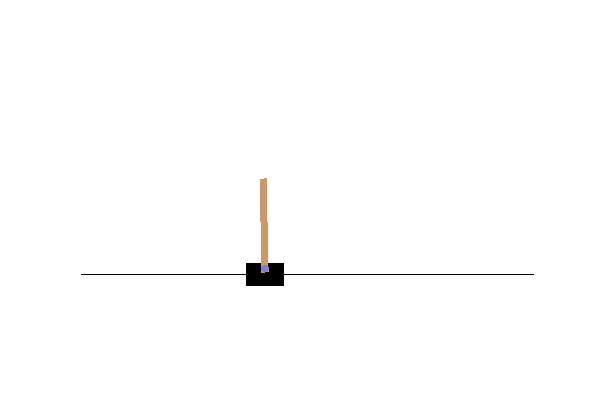
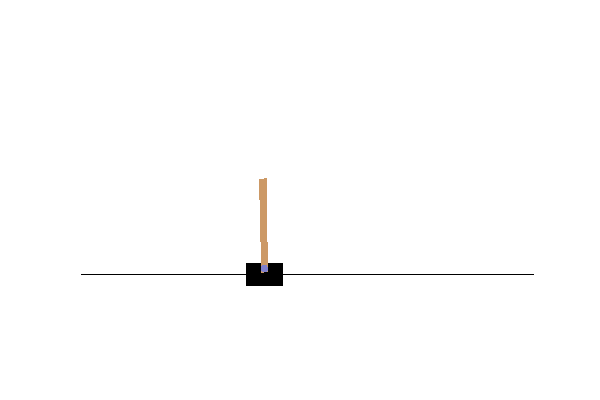
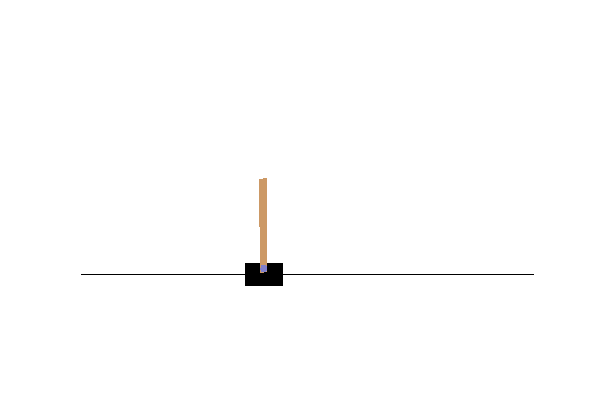
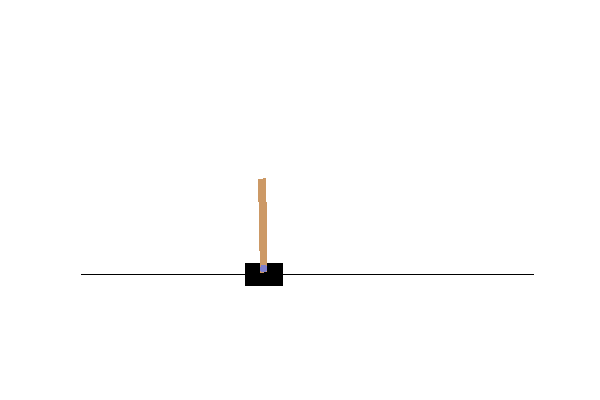
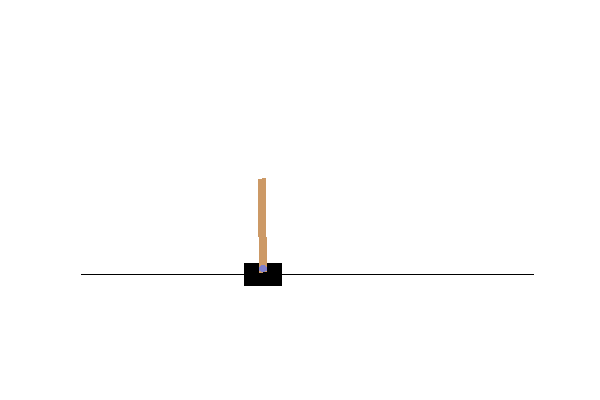
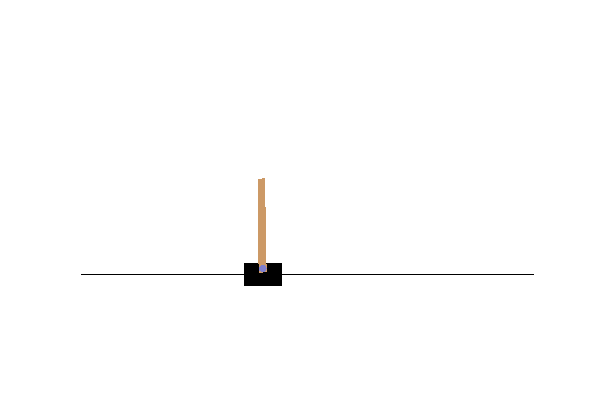
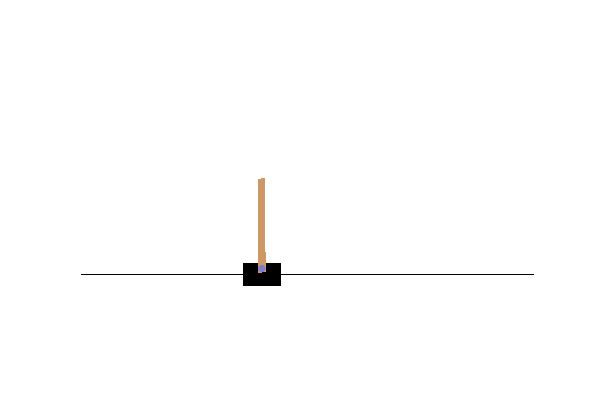
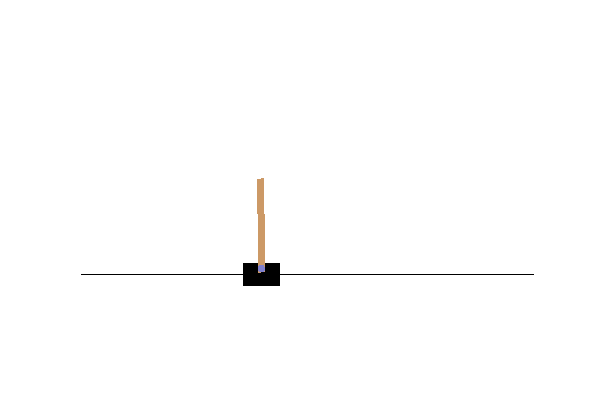
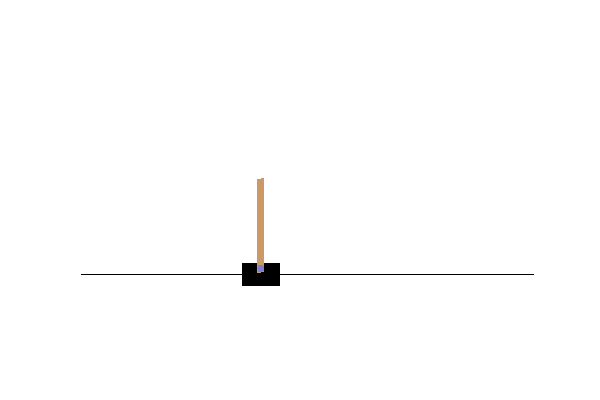
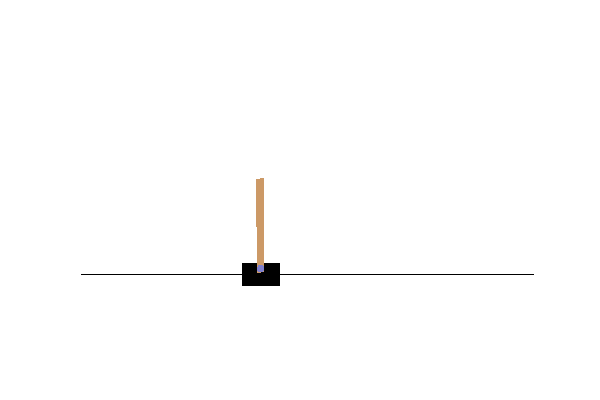
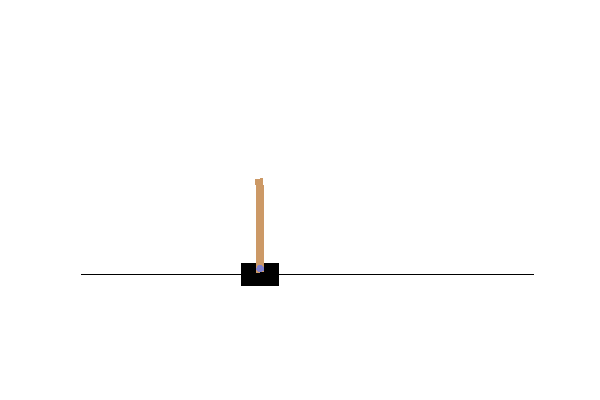
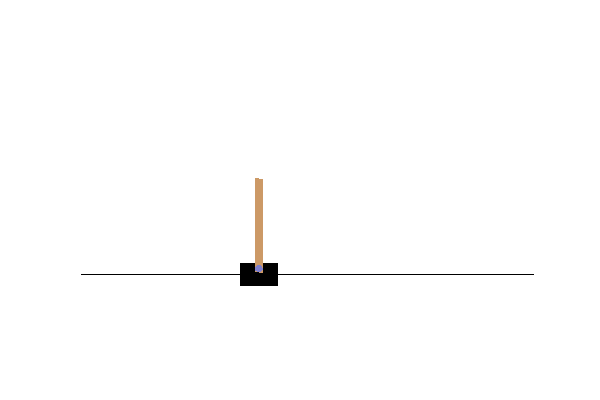
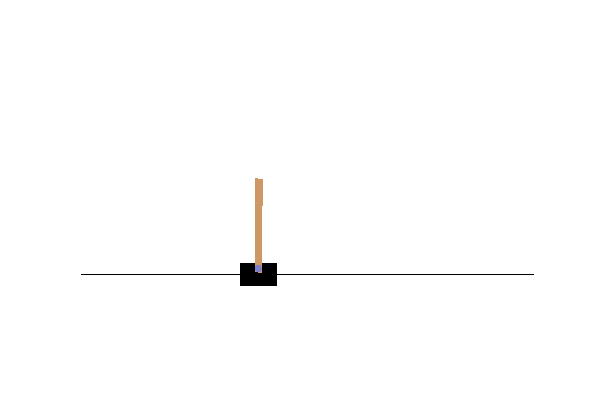
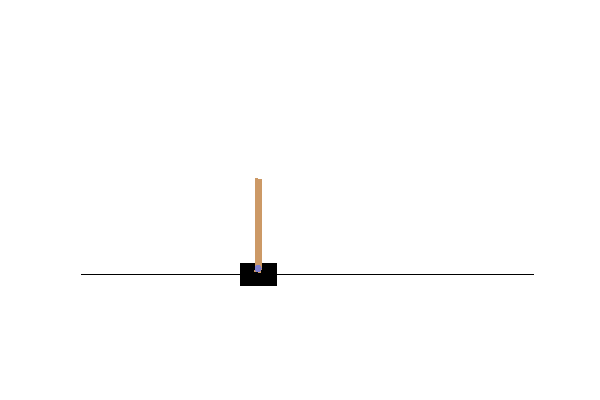
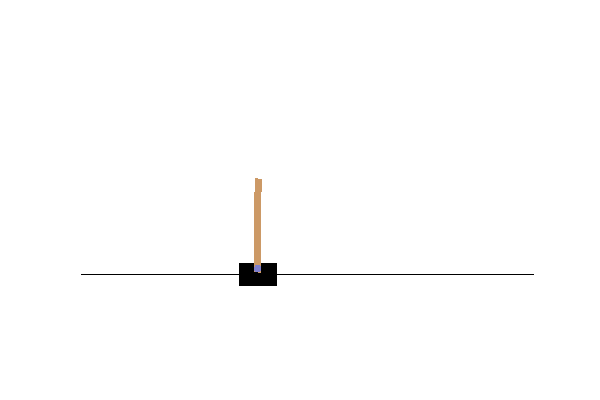
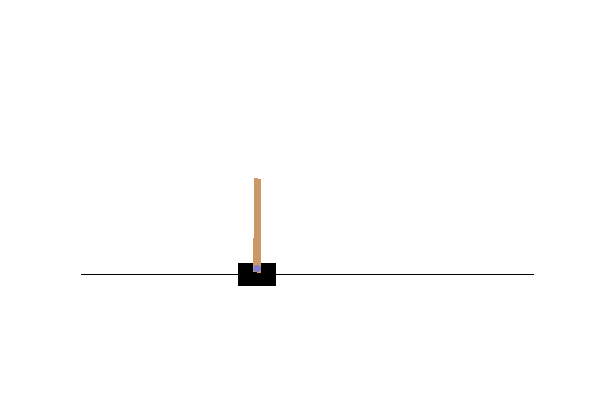
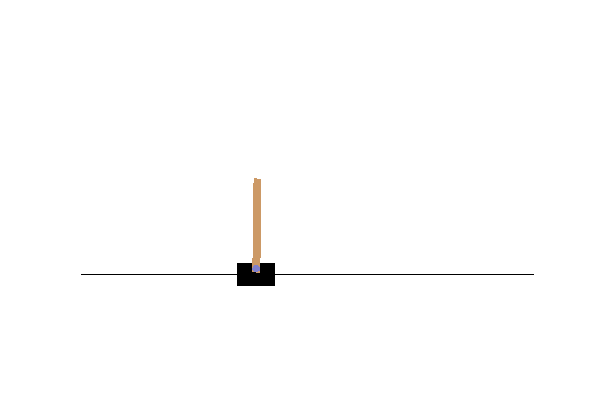
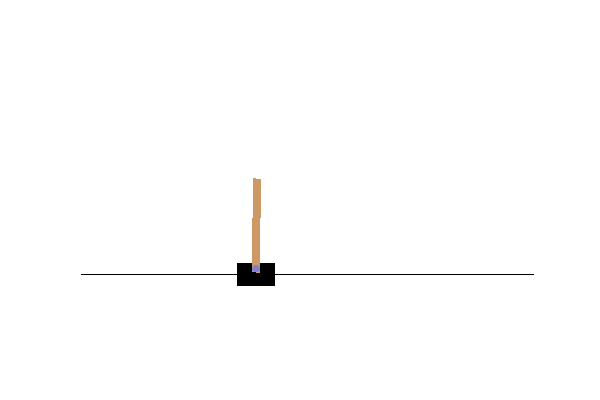
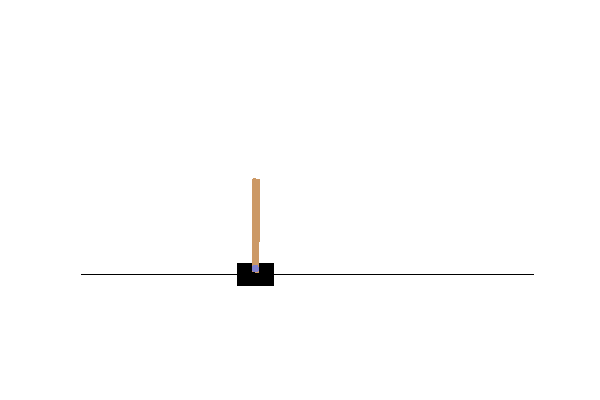
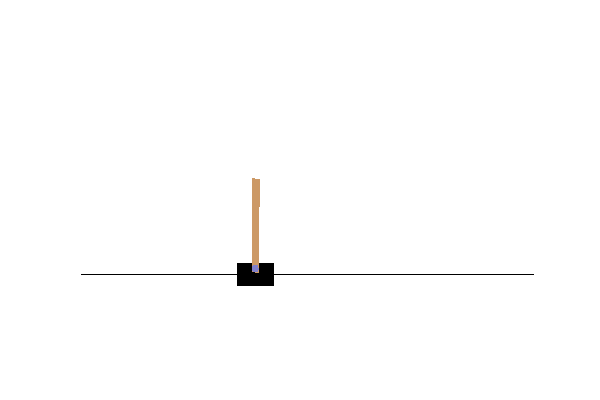
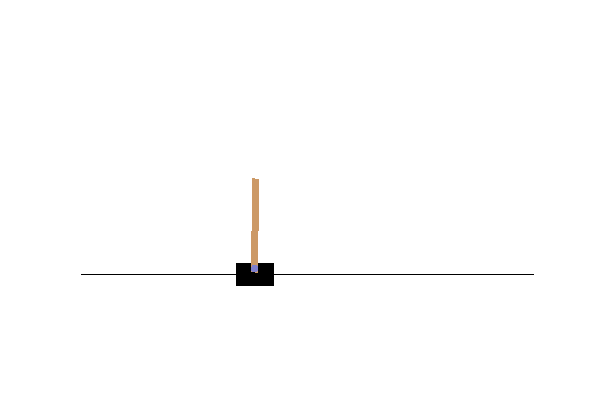
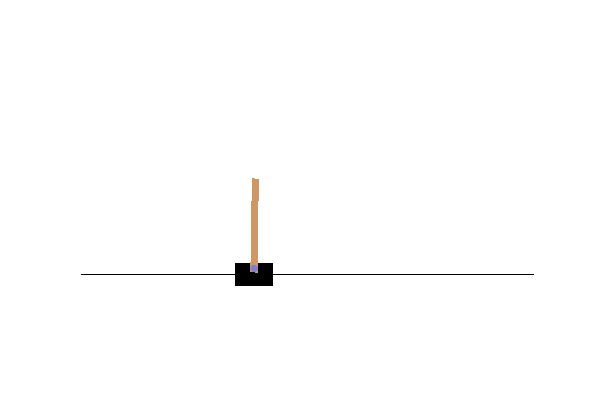
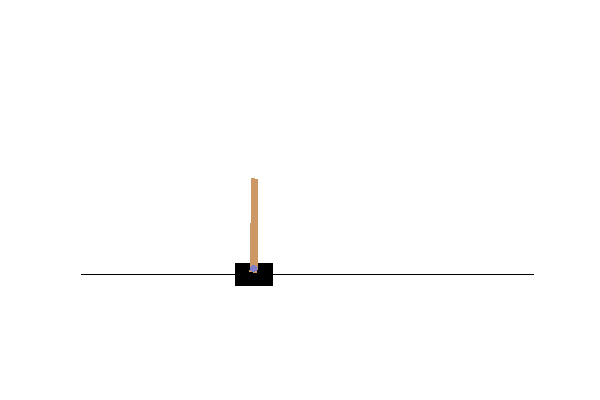
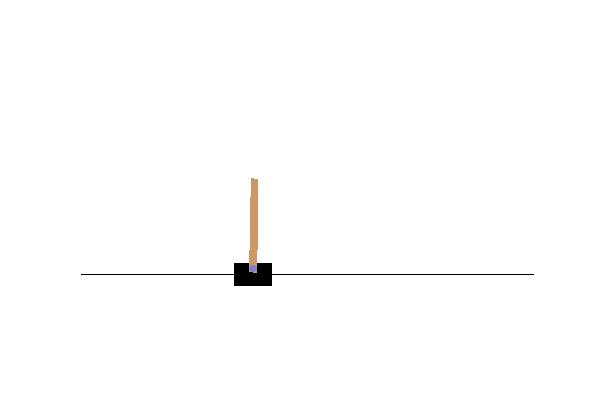
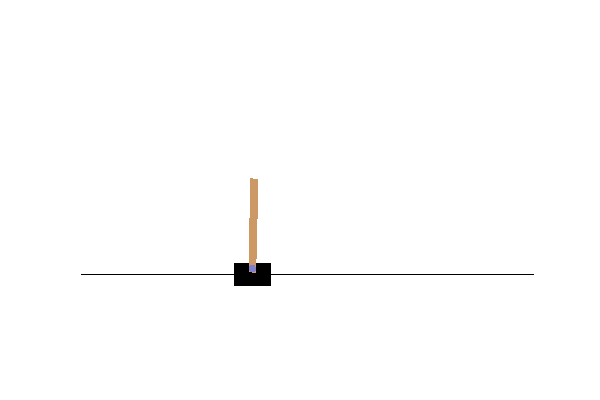
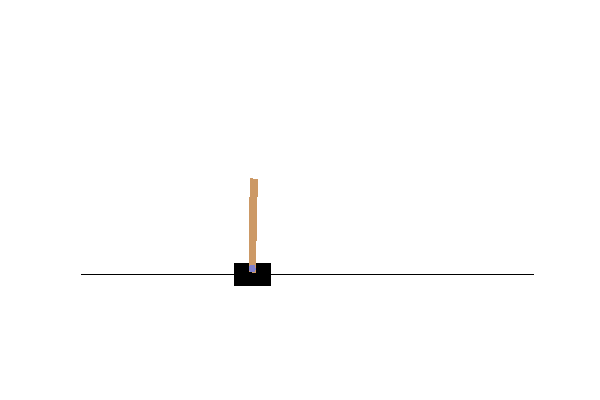
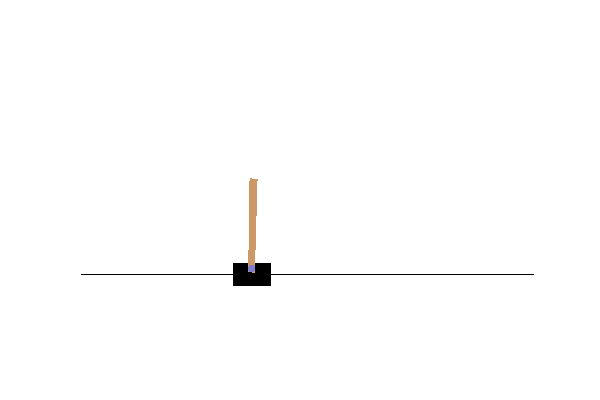
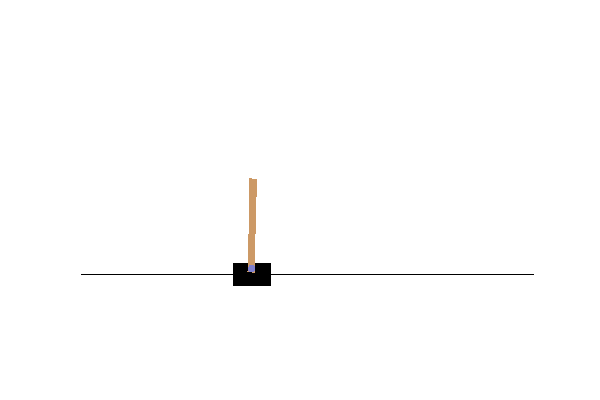
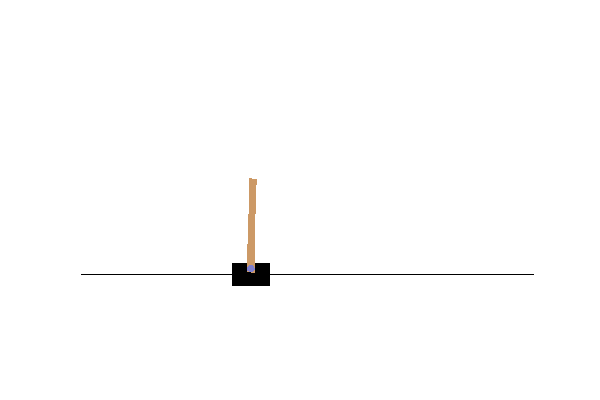
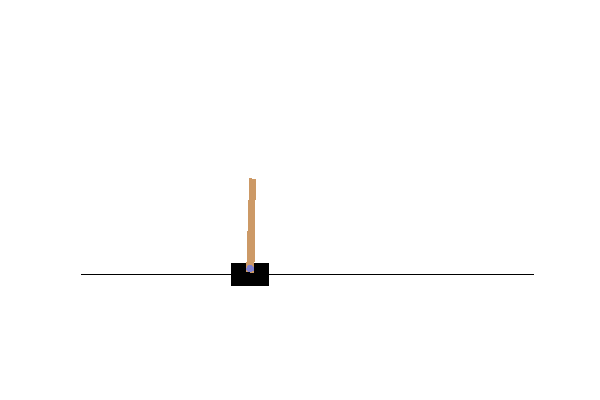
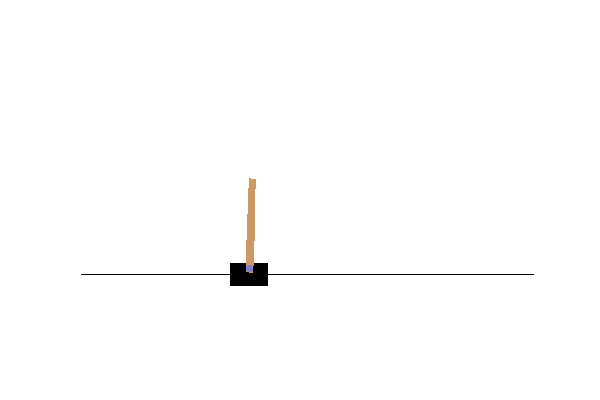
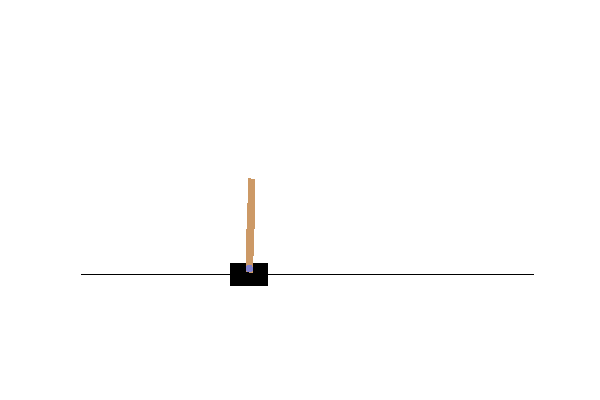
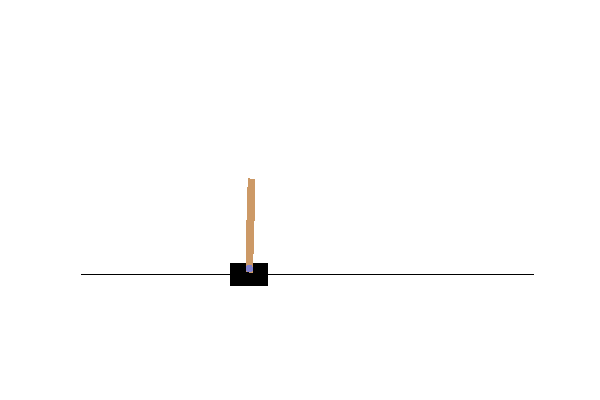
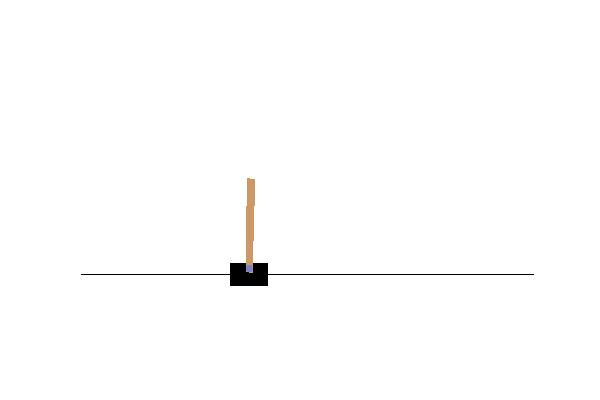
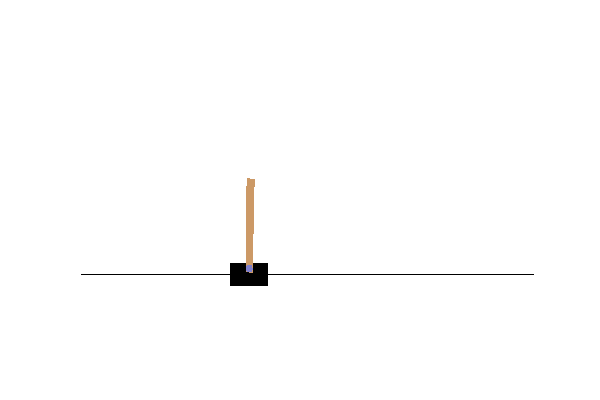
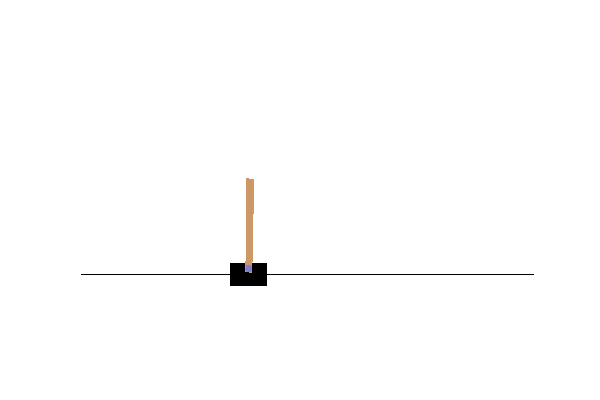
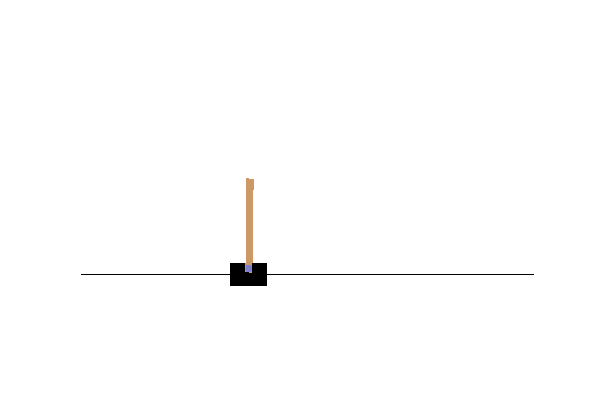
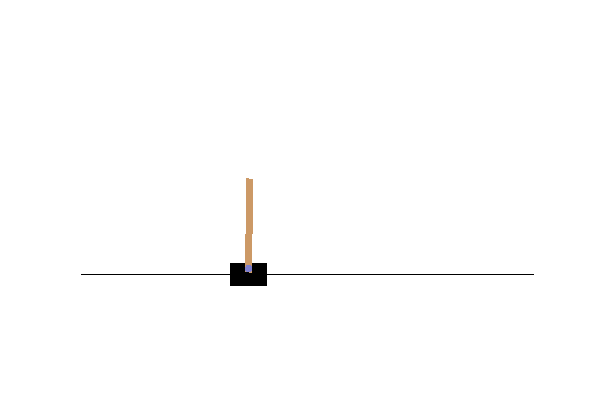
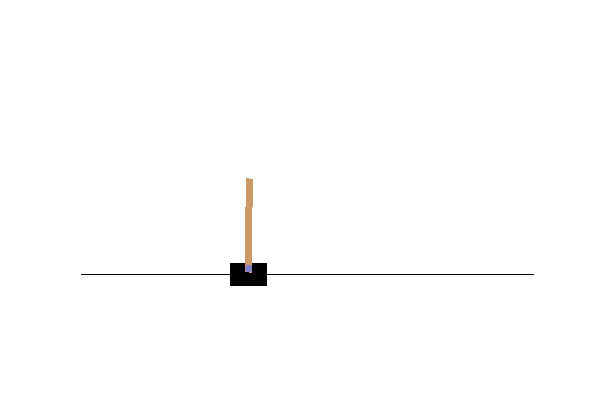
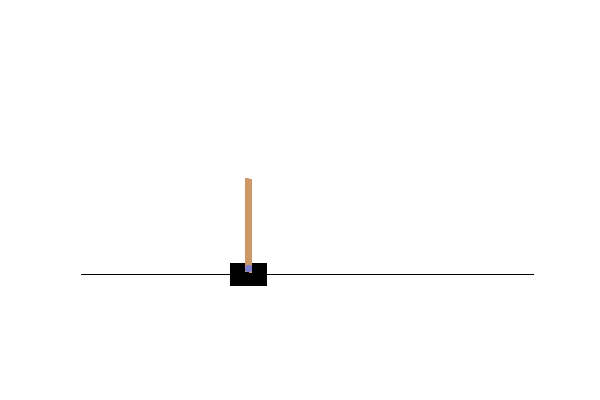
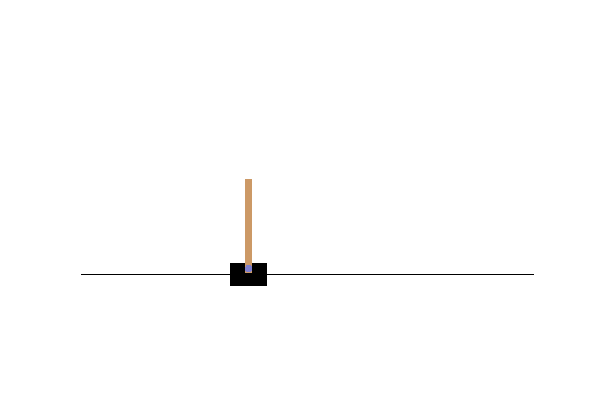
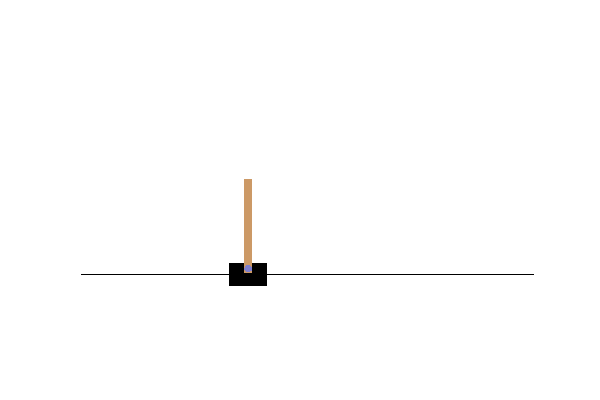
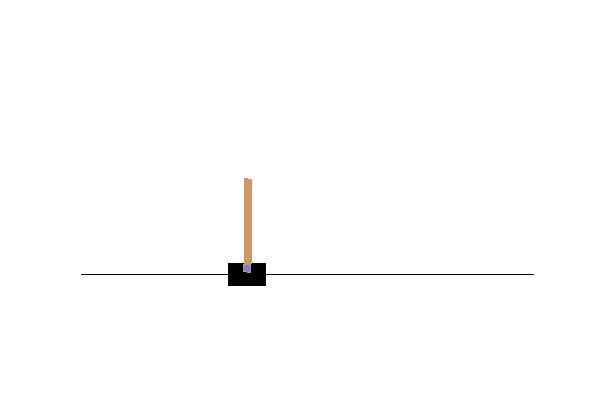
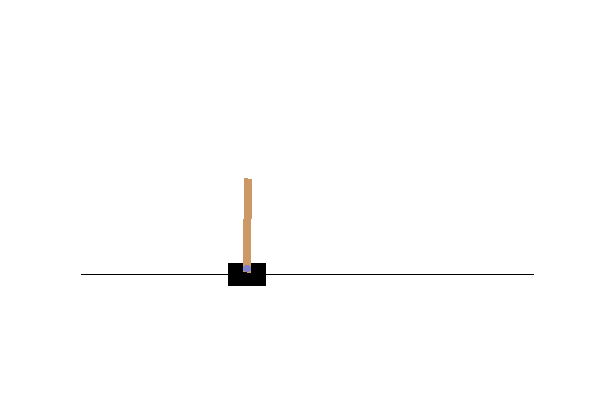
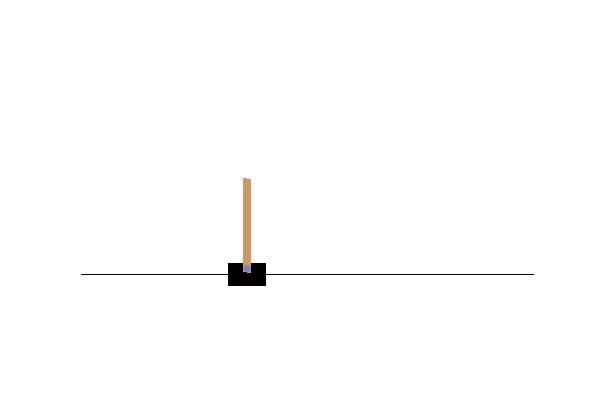
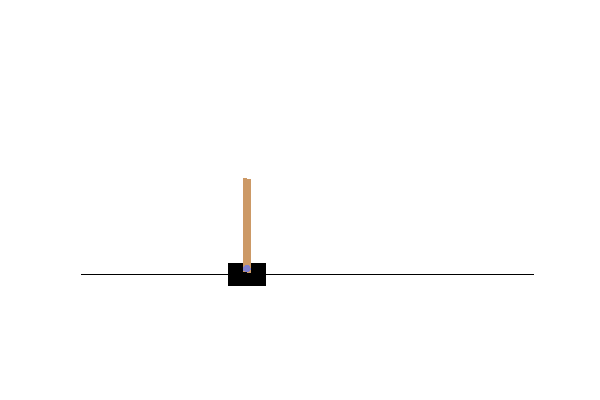
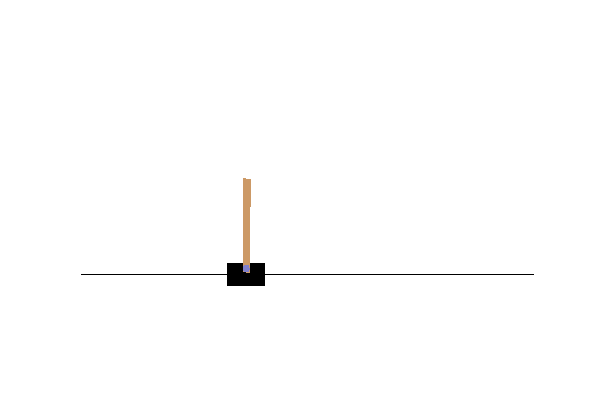
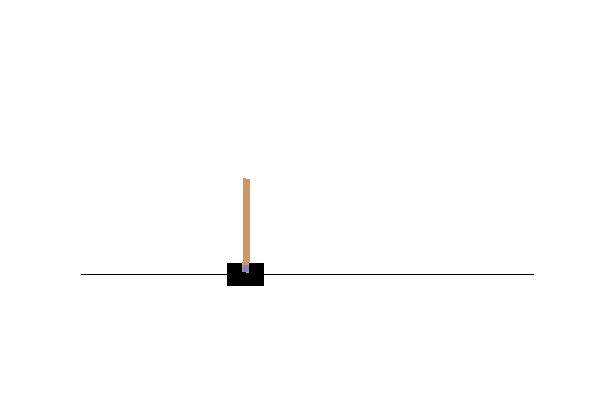
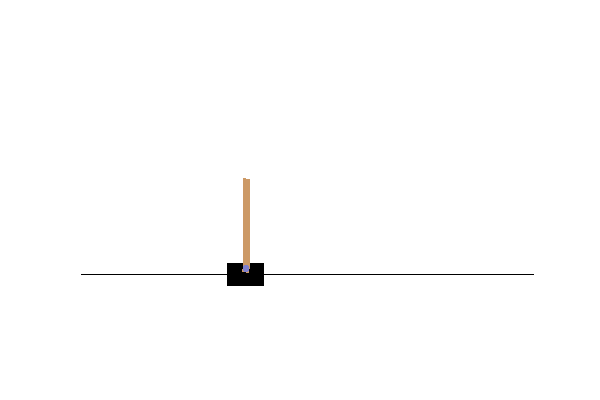
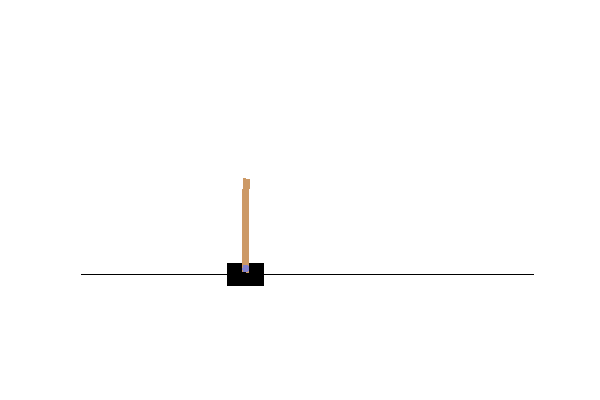
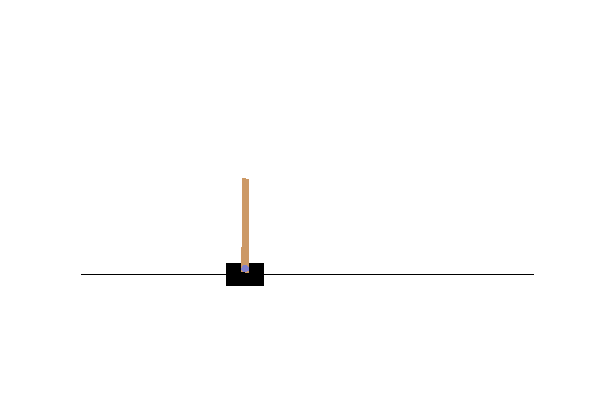
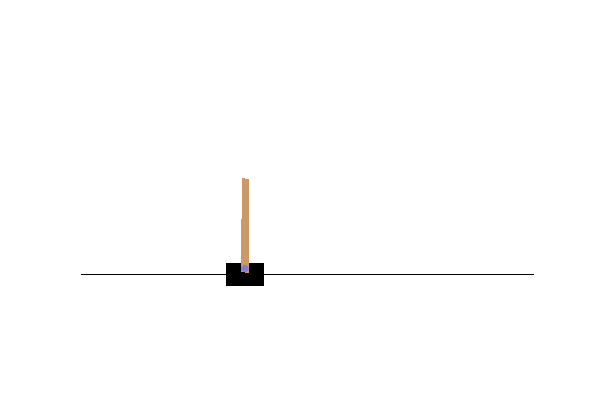
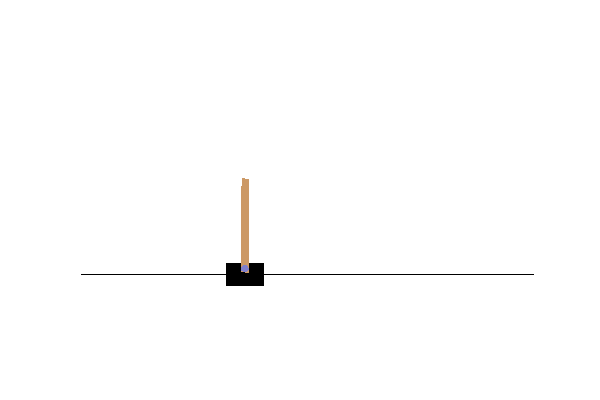
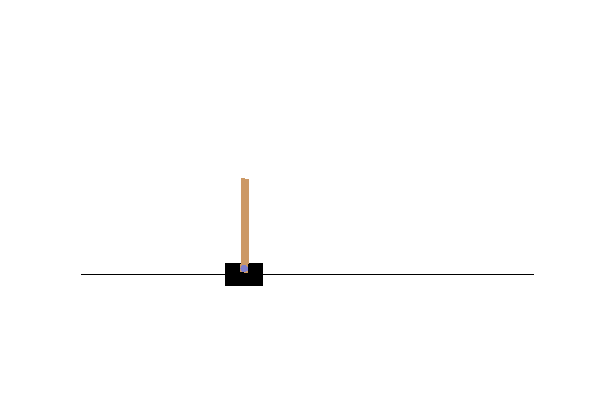
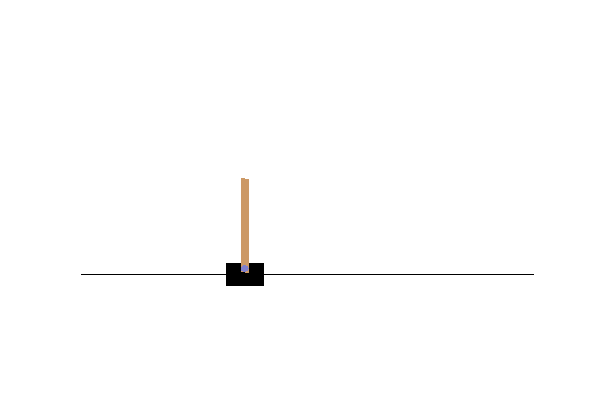
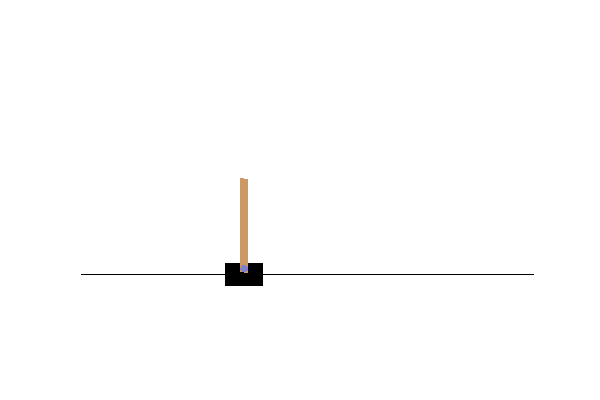
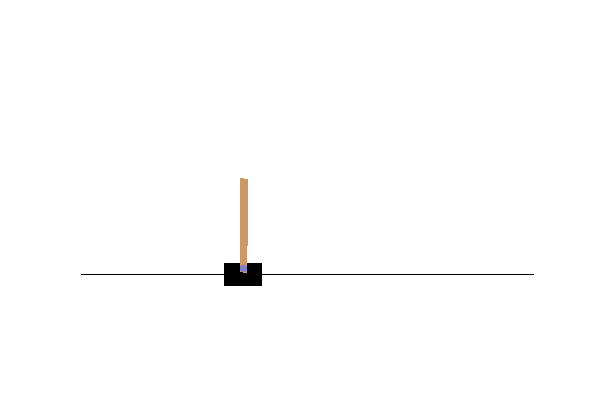
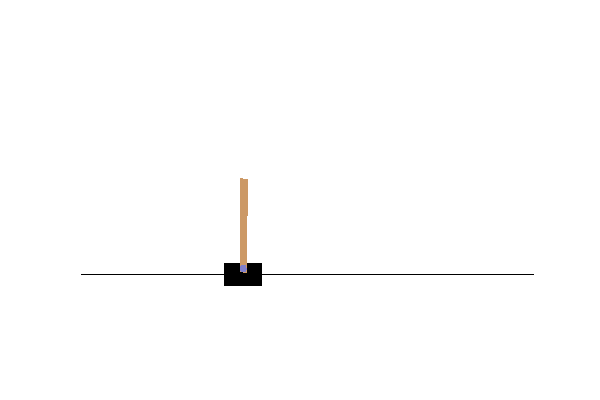
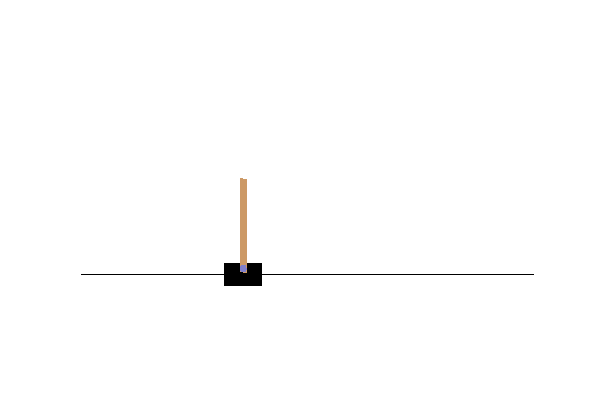
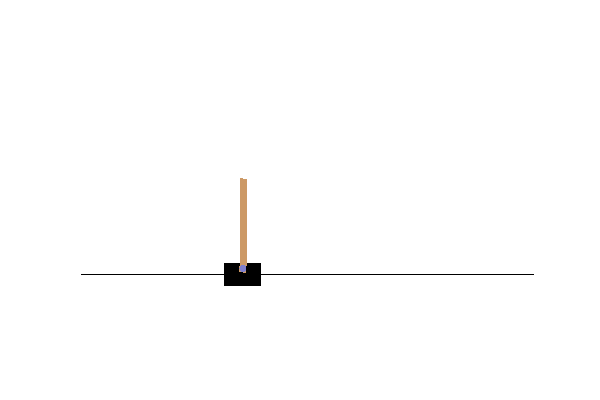
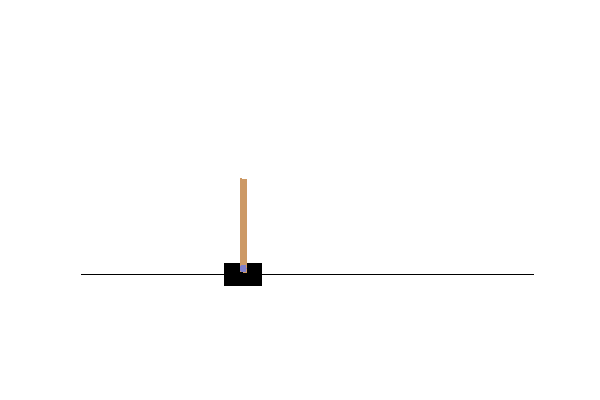
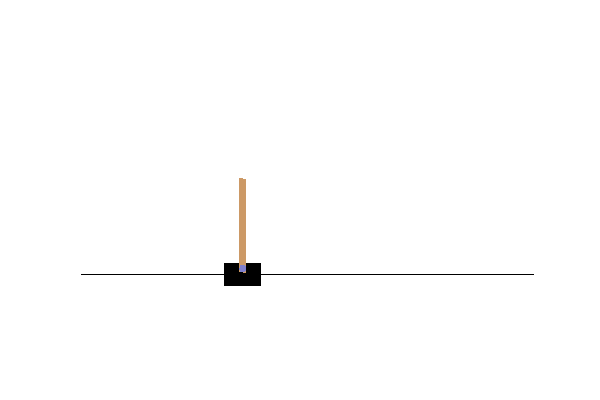
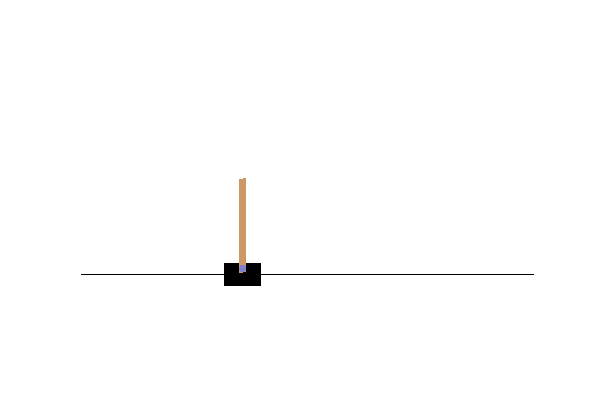
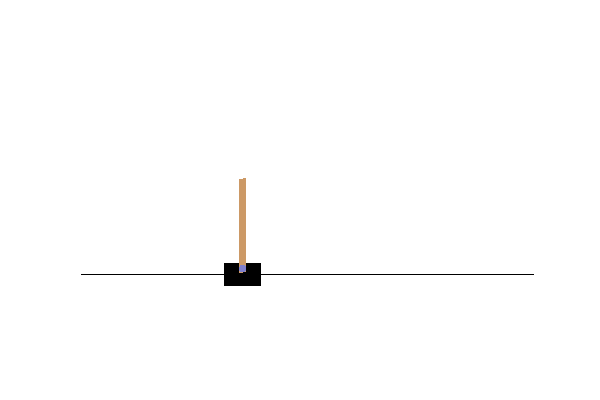
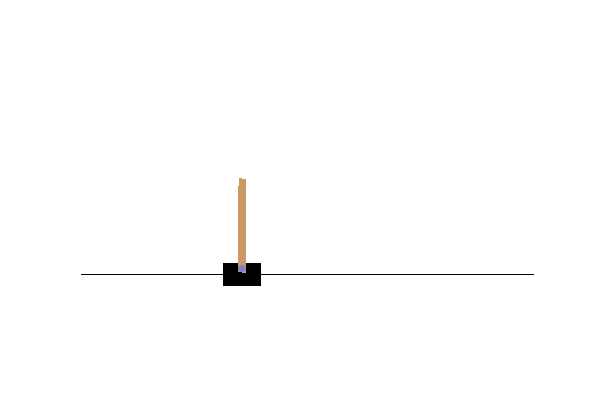

In [49]:
cartpole_env = Environment()
cartpole_env.run()